In [1]:
#Transfer Learning

In [146]:
import numpy as np
import pandas as pd
import os
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV,cross_val_score,train_test_split, KFold
from sklearn.metrics import mean_squared_error


import tensorflow.keras as keras


In [147]:
df = pd.read_csv(os.path.join("data", "merge_df.csv"))
df['Cell Count (million per mL)'].min()*0.1

0.020000000000000004

In [148]:
x_arr = np.array(df.drop(columns=['Cell Count (million per mL)']), np.float32)
x_shaped = x_arr.reshape(x_arr.shape[0], 1, x_arr.shape[1])

y_shaped = df['Cell Count (million per mL)'].values

kf = KFold(n_splits=4, shuffle=True)
kf.get_n_splits(x_shaped)

print(kf)


KFold(n_splits=4, random_state=None, shuffle=True)


In [149]:
df

,pH,Temperature (°C),D.O. (mg/L),Turbidity (NTU),NO3-N (mg/L),NH4-N (mg/L),ORP (MV),Conductivity (mS/cm),Cell Count (million per mL)
0,6.38191,15.2769,9.01400,80.6701,50.8520,13.34180,138.5530,1.074610,2.50
1,6.45090,16.7349,9.76380,79.2562,51.2915,13.09790,187.5780,1.078120,2.55
2,6.70017,17.4635,13.90520,49.9020,53.4964,14.35720,51.9092,1.083500,2.80
3,6.24448,18.6916,13.71210,23.0689,51.9471,11.48880,194.6270,1.072750,3.60
4,6.06136,17.8020,3.92154,14.8174,53.7670,10.26250,240.7050,1.086920,3.17
...,...,...,...,...,...,...,...,...,...
57,5.59588,19.4282,8.49871,53.3852,44.4436,5.95761,255.1880,0.756091,0.80
58,9.49382,19.6184,11.47510,66.2529,38.4451,4.30447,105.4210,0.744244,0.80
59,8.31171,20.3495,11.34420,60.6900,40.9638,6.17673,98.0507,0.790123,1.75
60,8.31922,21.4719,11.30530,56.4719,42.7059,6.41361,102.7290,0.807686,1.80


In [157]:
model = keras.models.load_model('best_model')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, None, 100)         33000     
                                                                 
 gru_3 (GRU)                 (None, None, 144)         106272    
                                                                 
 reshape_1 (Reshape)         (None, 12, 12)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 12, 128)           6272      
                                                                 
 conv1d_3 (Conv1D)           (None, 12, 64)            32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 6, 64)            0         
 1D)                                                             
                                                      

In [158]:
#Freeze layers   
for layer in model.layers[:3]:
    layer.trainable = False

In [152]:
model = keras.models.load_model('best_model_cell_count')
old_rmse = model.evaluate(x_test, y_test)[1]

1/1 [==============================] - 1s 556ms/step - loss: 0.5178 - root_mean_squared_error: 0.7196


In [159]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.00001),  
              loss='mse',
              metrics=[keras.metrics.RootMeanSquaredError()]
        )

In [160]:
models = []
histories = []  
model_evals = []
early_stopping = keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True, monitor='loss')
for train_index, test_index in kf.split(x_shaped):
    x_train, x_test = x_shaped[train_index], x_shaped[test_index]
    y_train, y_test = y_shaped[train_index], y_shaped[test_index]

    history = model.fit(x_train,y_train,epochs=5000, callbacks=[early_stopping])
    
    model_eval = model.evaluate(x_test, y_test)
    models.append(model)
    histories.append(history)
    model_evals.append(model_eval)
        

Epoch 1/5000
2/2 [==============================] - 2s 21ms/step - loss: 149089.5781 - root_mean_squared_error: 386.1212
Epoch 2/5000
2/2 [==============================] - 0s 11ms/step - loss: 146592.5312 - root_mean_squared_error: 382.8741
Epoch 3/5000
2/2 [==============================] - 0s 8ms/step - loss: 144852.6562 - root_mean_squared_error: 380.5951
Epoch 4/5000
2/2 [==============================] - 0s 9ms/step - loss: 143390.8125 - root_mean_squared_error: 378.6698
Epoch 5/5000
2/2 [==============================] - 0s 10ms/step - loss: 142091.5156 - root_mean_squared_error: 376.9503
Epoch 6/5000
2/2 [==============================] - 0s 10ms/step - loss: 140910.2969 - root_mean_squared_error: 375.3802
Epoch 7/5000
2/2 [==============================] - 0s 10ms/step - loss: 139790.3125 - root_mean_squared_error: 373.8854
Epoch 8/5000
2/2 [==============================] - 0s 9ms/step - loss: 138699.7344 - root_mean_squared_error: 372.4241
Epoch 9/5000
2/2 [=================

2/2 [==============================] - 0s 10ms/step - loss: 87975.5078 - root_mean_squared_error: 296.6067
Epoch 69/5000
2/2 [==============================] - 0s 13ms/step - loss: 87246.3125 - root_mean_squared_error: 295.3749
Epoch 70/5000
2/2 [==============================] - 0s 9ms/step - loss: 86518.8438 - root_mean_squared_error: 294.1409
Epoch 71/5000
2/2 [==============================] - 0s 9ms/step - loss: 85786.5000 - root_mean_squared_error: 292.8933
Epoch 72/5000
2/2 [==============================] - 0s 10ms/step - loss: 85056.7734 - root_mean_squared_error: 291.6450
Epoch 73/5000
2/2 [==============================] - 0s 8ms/step - loss: 84326.9531 - root_mean_squared_error: 290.3910
Epoch 74/5000
2/2 [==============================] - 0s 8ms/step - loss: 83613.7812 - root_mean_squared_error: 289.1605
Epoch 75/5000
2/2 [==============================] - 0s 8ms/step - loss: 82910.7578 - root_mean_squared_error: 287.9423
Epoch 76/5000
2/2 [==============================] 

2/2 [==============================] - 0s 10ms/step - loss: 45741.0820 - root_mean_squared_error: 213.8716
Epoch 136/5000
2/2 [==============================] - 0s 9ms/step - loss: 45216.9336 - root_mean_squared_error: 212.6427
Epoch 137/5000
2/2 [==============================] - 0s 8ms/step - loss: 44701.8086 - root_mean_squared_error: 211.4280
Epoch 138/5000
2/2 [==============================] - 0s 8ms/step - loss: 44186.8633 - root_mean_squared_error: 210.2067
Epoch 139/5000
2/2 [==============================] - 0s 8ms/step - loss: 43678.0586 - root_mean_squared_error: 208.9930
Epoch 140/5000
2/2 [==============================] - 0s 8ms/step - loss: 43170.1016 - root_mean_squared_error: 207.7742
Epoch 141/5000
2/2 [==============================] - 0s 7ms/step - loss: 42666.6055 - root_mean_squared_error: 206.5590
Epoch 142/5000
2/2 [==============================] - 0s 7ms/step - loss: 42164.0234 - root_mean_squared_error: 205.3388
Epoch 143/5000
2/2 [==========================

2/2 [==============================] - 0s 8ms/step - loss: 18090.5957 - root_mean_squared_error: 134.5013
Epoch 203/5000
2/2 [==============================] - 0s 8ms/step - loss: 17785.9258 - root_mean_squared_error: 133.3639
Epoch 204/5000
2/2 [==============================] - 0s 7ms/step - loss: 17481.4609 - root_mean_squared_error: 132.2175
Epoch 205/5000
2/2 [==============================] - 0s 8ms/step - loss: 17178.1465 - root_mean_squared_error: 131.0654
Epoch 206/5000
2/2 [==============================] - 0s 9ms/step - loss: 16877.3438 - root_mean_squared_error: 129.9128
Epoch 207/5000
2/2 [==============================] - 0s 9ms/step - loss: 16576.5020 - root_mean_squared_error: 128.7498
Epoch 208/5000
2/2 [==============================] - 0s 9ms/step - loss: 16283.3584 - root_mean_squared_error: 127.6063
Epoch 209/5000
2/2 [==============================] - 0s 9ms/step - loss: 15995.6191 - root_mean_squared_error: 126.4738
Epoch 210/5000
2/2 [===========================

2/2 [==============================] - 0s 11ms/step - loss: 3651.2786 - root_mean_squared_error: 60.4258
Epoch 271/5000
2/2 [==============================] - 0s 10ms/step - loss: 3535.6921 - root_mean_squared_error: 59.4617
Epoch 272/5000
2/2 [==============================] - 0s 11ms/step - loss: 3419.9712 - root_mean_squared_error: 58.4805
Epoch 273/5000
2/2 [==============================] - 0s 11ms/step - loss: 3307.7046 - root_mean_squared_error: 57.5126
Epoch 274/5000
2/2 [==============================] - 0s 14ms/step - loss: 3197.9399 - root_mean_squared_error: 56.5503
Epoch 275/5000
2/2 [==============================] - 0s 8ms/step - loss: 3087.6711 - root_mean_squared_error: 55.5668
Epoch 276/5000
2/2 [==============================] - 0s 7ms/step - loss: 2983.6387 - root_mean_squared_error: 54.6227
Epoch 277/5000
2/2 [==============================] - 0s 10ms/step - loss: 2881.8237 - root_mean_squared_error: 53.6826
Epoch 278/5000
2/2 [==============================] - 0s 

Epoch 339/5000
2/2 [==============================] - 0s 10ms/step - loss: 568.9971 - root_mean_squared_error: 23.8537
Epoch 340/5000
2/2 [==============================] - 0s 9ms/step - loss: 567.8026 - root_mean_squared_error: 23.8286
Epoch 341/5000
2/2 [==============================] - 0s 10ms/step - loss: 564.6725 - root_mean_squared_error: 23.7628
Epoch 342/5000
2/2 [==============================] - 0s 10ms/step - loss: 563.8109 - root_mean_squared_error: 23.7447
Epoch 343/5000
2/2 [==============================] - 0s 9ms/step - loss: 561.3885 - root_mean_squared_error: 23.6936
Epoch 344/5000
2/2 [==============================] - 0s 9ms/step - loss: 558.5171 - root_mean_squared_error: 23.6330
Epoch 345/5000
2/2 [==============================] - 0s 12ms/step - loss: 556.2355 - root_mean_squared_error: 23.5846
Epoch 346/5000
2/2 [==============================] - 0s 10ms/step - loss: 553.5963 - root_mean_squared_error: 23.5286
Epoch 347/5000
2/2 [==============================]

2/2 [==============================] - 0s 10ms/step - loss: 438.5661 - root_mean_squared_error: 20.9420
Epoch 409/5000
2/2 [==============================] - 0s 6ms/step - loss: 438.7477 - root_mean_squared_error: 20.9463
Epoch 410/5000
2/2 [==============================] - 0s 8ms/step - loss: 435.8290 - root_mean_squared_error: 20.8765
Epoch 411/5000
2/2 [==============================] - 0s 9ms/step - loss: 433.8128 - root_mean_squared_error: 20.8282
Epoch 412/5000
2/2 [==============================] - 0s 9ms/step - loss: 431.3055 - root_mean_squared_error: 20.7679
Epoch 413/5000
2/2 [==============================] - 0s 11ms/step - loss: 429.5923 - root_mean_squared_error: 20.7266
Epoch 414/5000
2/2 [==============================] - 0s 10ms/step - loss: 427.7687 - root_mean_squared_error: 20.6826
Epoch 415/5000
2/2 [==============================] - 0s 11ms/step - loss: 427.3913 - root_mean_squared_error: 20.6734
Epoch 416/5000
2/2 [==============================] - 0s 9ms/step -

2/2 [==============================] - 0s 10ms/step - loss: 342.4441 - root_mean_squared_error: 18.5052
Epoch 478/5000
2/2 [==============================] - 0s 7ms/step - loss: 344.3745 - root_mean_squared_error: 18.5573
Epoch 479/5000
2/2 [==============================] - 0s 12ms/step - loss: 339.9866 - root_mean_squared_error: 18.4387
Epoch 480/5000
2/2 [==============================] - 0s 11ms/step - loss: 339.5184 - root_mean_squared_error: 18.4260
Epoch 481/5000
2/2 [==============================] - 0s 10ms/step - loss: 339.4165 - root_mean_squared_error: 18.4233
Epoch 482/5000
2/2 [==============================] - 0s 10ms/step - loss: 339.1048 - root_mean_squared_error: 18.4148
Epoch 483/5000
2/2 [==============================] - 0s 9ms/step - loss: 337.6047 - root_mean_squared_error: 18.3740
Epoch 484/5000
2/2 [==============================] - 0s 8ms/step - loss: 335.9953 - root_mean_squared_error: 18.3302
Epoch 485/5000
2/2 [==============================] - 0s 10ms/step

2/2 [==============================] - 0s 10ms/step - loss: 277.8653 - root_mean_squared_error: 16.6693
Epoch 547/5000
2/2 [==============================] - 0s 7ms/step - loss: 282.4116 - root_mean_squared_error: 16.8051
Epoch 548/5000
2/2 [==============================] - 0s 8ms/step - loss: 276.4770 - root_mean_squared_error: 16.6276
Epoch 549/5000
2/2 [==============================] - 0s 9ms/step - loss: 276.0763 - root_mean_squared_error: 16.6155
Epoch 550/5000
2/2 [==============================] - 0s 10ms/step - loss: 275.6822 - root_mean_squared_error: 16.6037
Epoch 551/5000
2/2 [==============================] - 0s 20ms/step - loss: 275.4047 - root_mean_squared_error: 16.5953
Epoch 552/5000
2/2 [==============================] - 0s 21ms/step - loss: 274.7596 - root_mean_squared_error: 16.5759
Epoch 553/5000
2/2 [==============================] - 0s 24ms/step - loss: 272.8381 - root_mean_squared_error: 16.5178
Epoch 554/5000
2/2 [==============================] - 0s 24ms/step

2/2 [==============================] - 0s 9ms/step - loss: 229.6973 - root_mean_squared_error: 15.1558
Epoch 616/5000
2/2 [==============================] - 0s 9ms/step - loss: 229.1074 - root_mean_squared_error: 15.1363
Epoch 617/5000
2/2 [==============================] - 0s 11ms/step - loss: 228.9796 - root_mean_squared_error: 15.1321
Epoch 618/5000
2/2 [==============================] - 0s 9ms/step - loss: 227.5272 - root_mean_squared_error: 15.0840
Epoch 619/5000
2/2 [==============================] - 0s 18ms/step - loss: 227.3386 - root_mean_squared_error: 15.0778
Epoch 620/5000
2/2 [==============================] - 0s 12ms/step - loss: 227.1690 - root_mean_squared_error: 15.0721
Epoch 621/5000
2/2 [==============================] - 0s 10ms/step - loss: 225.2284 - root_mean_squared_error: 15.0076
Epoch 622/5000
2/2 [==============================] - 0s 10ms/step - loss: 224.5345 - root_mean_squared_error: 14.9845
Epoch 623/5000
2/2 [==============================] - 0s 9ms/step 

2/2 [==============================] - 0s 9ms/step - loss: 190.2067 - root_mean_squared_error: 13.7915
Epoch 685/5000
2/2 [==============================] - 0s 10ms/step - loss: 189.5842 - root_mean_squared_error: 13.7690
Epoch 686/5000
2/2 [==============================] - 0s 9ms/step - loss: 190.0991 - root_mean_squared_error: 13.7876
Epoch 687/5000
2/2 [==============================] - 0s 9ms/step - loss: 188.7157 - root_mean_squared_error: 13.7374
Epoch 688/5000
2/2 [==============================] - 0s 9ms/step - loss: 188.2840 - root_mean_squared_error: 13.7217
Epoch 689/5000
2/2 [==============================] - 0s 11ms/step - loss: 187.4450 - root_mean_squared_error: 13.6911
Epoch 690/5000
2/2 [==============================] - 0s 10ms/step - loss: 187.7206 - root_mean_squared_error: 13.7011
Epoch 691/5000
2/2 [==============================] - 0s 12ms/step - loss: 186.5930 - root_mean_squared_error: 13.6599
Epoch 692/5000
2/2 [==============================] - 0s 9ms/step -

2/2 [==============================] - 0s 9ms/step - loss: 163.5589 - root_mean_squared_error: 12.7890
Epoch 754/5000
2/2 [==============================] - 0s 7ms/step - loss: 165.2034 - root_mean_squared_error: 12.8531
Epoch 755/5000
2/2 [==============================] - 0s 10ms/step - loss: 163.1598 - root_mean_squared_error: 12.7734
Epoch 756/5000
2/2 [==============================] - 0s 10ms/step - loss: 162.4921 - root_mean_squared_error: 12.7472
Epoch 757/5000
2/2 [==============================] - 0s 9ms/step - loss: 162.0913 - root_mean_squared_error: 12.7315
Epoch 758/5000
2/2 [==============================] - 0s 6ms/step - loss: 162.2951 - root_mean_squared_error: 12.7395
Epoch 759/5000
2/2 [==============================] - 0s 13ms/step - loss: 161.9538 - root_mean_squared_error: 12.7261
Epoch 760/5000
2/2 [==============================] - 0s 9ms/step - loss: 161.2841 - root_mean_squared_error: 12.6998
Epoch 761/5000
2/2 [==============================] - 0s 8ms/step - 

2/2 [==============================] - 0s 14ms/step - loss: 141.9268 - root_mean_squared_error: 11.9133
Epoch 823/5000
2/2 [==============================] - 0s 9ms/step - loss: 142.0194 - root_mean_squared_error: 11.9172
Epoch 824/5000
2/2 [==============================] - 0s 14ms/step - loss: 141.7487 - root_mean_squared_error: 11.9058
Epoch 825/5000
2/2 [==============================] - 0s 11ms/step - loss: 140.8904 - root_mean_squared_error: 11.8697
Epoch 826/5000
2/2 [==============================] - 0s 11ms/step - loss: 140.5857 - root_mean_squared_error: 11.8569
Epoch 827/5000
2/2 [==============================] - 0s 10ms/step - loss: 141.1007 - root_mean_squared_error: 11.8786
Epoch 828/5000
2/2 [==============================] - 0s 12ms/step - loss: 140.4153 - root_mean_squared_error: 11.8497
Epoch 829/5000
2/2 [==============================] - 0s 13ms/step - loss: 139.7465 - root_mean_squared_error: 11.8214
Epoch 830/5000
2/2 [==============================] - 0s 9ms/ste

2/2 [==============================] - 0s 7ms/step - loss: 124.4435 - root_mean_squared_error: 11.1554
Epoch 892/5000
2/2 [==============================] - 0s 11ms/step - loss: 123.8997 - root_mean_squared_error: 11.1310
Epoch 893/5000
2/2 [==============================] - 0s 9ms/step - loss: 126.4173 - root_mean_squared_error: 11.2435
Epoch 894/5000
2/2 [==============================] - 0s 7ms/step - loss: 124.0029 - root_mean_squared_error: 11.1357
Epoch 895/5000
2/2 [==============================] - 0s 11ms/step - loss: 123.8147 - root_mean_squared_error: 11.1272
Epoch 896/5000
2/2 [==============================] - 0s 13ms/step - loss: 122.9520 - root_mean_squared_error: 11.0884
Epoch 897/5000
2/2 [==============================] - 0s 9ms/step - loss: 122.7292 - root_mean_squared_error: 11.0783
Epoch 898/5000
2/2 [==============================] - 0s 8ms/step - loss: 123.7866 - root_mean_squared_error: 11.1259
Epoch 899/5000
2/2 [==============================] - 0s 11ms/step -

2/2 [==============================] - 0s 6ms/step - loss: 110.0726 - root_mean_squared_error: 10.4916
Epoch 961/5000
2/2 [==============================] - 0s 10ms/step - loss: 110.0560 - root_mean_squared_error: 10.4908
Epoch 962/5000
2/2 [==============================] - 0s 12ms/step - loss: 108.8758 - root_mean_squared_error: 10.4344
Epoch 963/5000
2/2 [==============================] - 0s 8ms/step - loss: 108.7848 - root_mean_squared_error: 10.4300
Epoch 964/5000
2/2 [==============================] - 0s 11ms/step - loss: 108.5149 - root_mean_squared_error: 10.4170
Epoch 965/5000
2/2 [==============================] - 0s 10ms/step - loss: 108.3017 - root_mean_squared_error: 10.4068
Epoch 966/5000
2/2 [==============================] - 0s 10ms/step - loss: 108.1314 - root_mean_squared_error: 10.3986
Epoch 967/5000
2/2 [==============================] - 0s 11ms/step - loss: 107.9765 - root_mean_squared_error: 10.3912
Epoch 968/5000
2/2 [==============================] - 0s 10ms/ste

2/2 [==============================] - 0s 10ms/step - loss: 95.5477 - root_mean_squared_error: 9.7749
Epoch 1030/5000
2/2 [==============================] - 0s 10ms/step - loss: 95.4057 - root_mean_squared_error: 9.7676
Epoch 1031/5000
2/2 [==============================] - 0s 9ms/step - loss: 95.0843 - root_mean_squared_error: 9.7511
Epoch 1032/5000
2/2 [==============================] - 0s 10ms/step - loss: 94.6173 - root_mean_squared_error: 9.7271
Epoch 1033/5000
2/2 [==============================] - 0s 10ms/step - loss: 94.3185 - root_mean_squared_error: 9.7118
Epoch 1034/5000
2/2 [==============================] - 0s 10ms/step - loss: 94.2738 - root_mean_squared_error: 9.7095
Epoch 1035/5000
2/2 [==============================] - 0s 8ms/step - loss: 93.9530 - root_mean_squared_error: 9.6929
Epoch 1036/5000
2/2 [==============================] - 0s 5ms/step - loss: 94.9872 - root_mean_squared_error: 9.7461
Epoch 1037/5000
2/2 [==============================] - 0s 10ms/step - loss:

2/2 [==============================] - 0s 9ms/step - loss: 82.9742 - root_mean_squared_error: 9.1090
Epoch 1099/5000
2/2 [==============================] - 0s 7ms/step - loss: 83.7482 - root_mean_squared_error: 9.1514
Epoch 1100/5000
2/2 [==============================] - 0s 8ms/step - loss: 82.9321 - root_mean_squared_error: 9.1067
Epoch 1101/5000
2/2 [==============================] - 0s 9ms/step - loss: 82.4934 - root_mean_squared_error: 9.0826
Epoch 1102/5000
2/2 [==============================] - 0s 7ms/step - loss: 83.0608 - root_mean_squared_error: 9.1138
Epoch 1103/5000
2/2 [==============================] - 0s 9ms/step - loss: 82.0039 - root_mean_squared_error: 9.0556
Epoch 1104/5000
2/2 [==============================] - 0s 10ms/step - loss: 81.6661 - root_mean_squared_error: 9.0369
Epoch 1105/5000
2/2 [==============================] - 0s 8ms/step - loss: 81.5074 - root_mean_squared_error: 9.0281
Epoch 1106/5000
2/2 [==============================] - 0s 6ms/step - loss: 82.3

2/2 [==============================] - 0s 6ms/step - loss: 72.0739 - root_mean_squared_error: 8.4896
Epoch 1169/5000
2/2 [==============================] - 0s 9ms/step - loss: 71.4602 - root_mean_squared_error: 8.4534
Epoch 1170/5000
2/2 [==============================] - 0s 7ms/step - loss: 71.5077 - root_mean_squared_error: 8.4562
Epoch 1171/5000
2/2 [==============================] - 0s 8ms/step - loss: 70.6936 - root_mean_squared_error: 8.4079
Epoch 1172/5000
2/2 [==============================] - 0s 9ms/step - loss: 70.5900 - root_mean_squared_error: 8.4018
Epoch 1173/5000
2/2 [==============================] - 0s 10ms/step - loss: 70.3512 - root_mean_squared_error: 8.3876
Epoch 1174/5000
2/2 [==============================] - 0s 9ms/step - loss: 70.2795 - root_mean_squared_error: 8.3833
Epoch 1175/5000
2/2 [==============================] - 0s 6ms/step - loss: 70.3722 - root_mean_squared_error: 8.3888
Epoch 1176/5000
2/2 [==============================] - 0s 8ms/step - loss: 70.2

2/2 [==============================] - 0s 10ms/step - loss: 60.9841 - root_mean_squared_error: 7.8092
Epoch 1239/5000
2/2 [==============================] - 0s 11ms/step - loss: 60.7878 - root_mean_squared_error: 7.7967
Epoch 1240/5000
2/2 [==============================] - 0s 9ms/step - loss: 60.6346 - root_mean_squared_error: 7.7868
Epoch 1241/5000
2/2 [==============================] - 0s 9ms/step - loss: 62.2466 - root_mean_squared_error: 7.8896
Epoch 1242/5000
2/2 [==============================] - 0s 10ms/step - loss: 60.5976 - root_mean_squared_error: 7.7844
Epoch 1243/5000
2/2 [==============================] - 0s 8ms/step - loss: 60.2466 - root_mean_squared_error: 7.7619
Epoch 1244/5000
2/2 [==============================] - 0s 9ms/step - loss: 60.7943 - root_mean_squared_error: 7.7971
Epoch 1245/5000
2/2 [==============================] - 0s 8ms/step - loss: 60.2574 - root_mean_squared_error: 7.7626
Epoch 1246/5000
2/2 [==============================] - 0s 10ms/step - loss: 6

2/2 [==============================] - 0s 8ms/step - loss: 52.0106 - root_mean_squared_error: 7.2118
Epoch 1308/5000
2/2 [==============================] - 0s 19ms/step - loss: 51.6195 - root_mean_squared_error: 7.1847
Epoch 1309/5000
2/2 [==============================] - 0s 9ms/step - loss: 52.0664 - root_mean_squared_error: 7.2157
Epoch 1310/5000
2/2 [==============================] - 0s 10ms/step - loss: 52.9848 - root_mean_squared_error: 7.2791
Epoch 1311/5000
2/2 [==============================] - 0s 7ms/step - loss: 52.4158 - root_mean_squared_error: 7.2399
Epoch 1312/5000
2/2 [==============================] - 0s 7ms/step - loss: 52.8614 - root_mean_squared_error: 7.2706
Epoch 1313/5000
2/2 [==============================] - 0s 6ms/step - loss: 52.4880 - root_mean_squared_error: 7.2449
Epoch 1314/5000
2/2 [==============================] - 0s 10ms/step - loss: 51.6192 - root_mean_squared_error: 7.1847
Epoch 1315/5000
2/2 [==============================] - 0s 11ms/step - loss: 5

2/2 [==============================] - 0s 8ms/step - loss: 45.1791 - root_mean_squared_error: 6.7215
Epoch 1377/5000
2/2 [==============================] - 0s 12ms/step - loss: 44.5953 - root_mean_squared_error: 6.6780
Epoch 1378/5000
2/2 [==============================] - 0s 9ms/step - loss: 44.2784 - root_mean_squared_error: 6.6542
Epoch 1379/5000
2/2 [==============================] - 0s 7ms/step - loss: 44.3528 - root_mean_squared_error: 6.6598
Epoch 1380/5000
2/2 [==============================] - 0s 11ms/step - loss: 44.1805 - root_mean_squared_error: 6.6468
Epoch 1381/5000
2/2 [==============================] - 0s 10ms/step - loss: 43.9384 - root_mean_squared_error: 6.6286
Epoch 1382/5000
2/2 [==============================] - 0s 9ms/step - loss: 43.8191 - root_mean_squared_error: 6.6196
Epoch 1383/5000
2/2 [==============================] - 0s 9ms/step - loss: 43.9074 - root_mean_squared_error: 6.6263
Epoch 1384/5000
2/2 [==============================] - 0s 9ms/step - loss: 44

2/2 [==============================] - 0s 10ms/step - loss: 37.6353 - root_mean_squared_error: 6.1348
Epoch 1446/5000
2/2 [==============================] - 0s 8ms/step - loss: 38.0144 - root_mean_squared_error: 6.1656
Epoch 1447/5000
2/2 [==============================] - 0s 8ms/step - loss: 38.1381 - root_mean_squared_error: 6.1756
Epoch 1448/5000
2/2 [==============================] - 0s 7ms/step - loss: 37.9280 - root_mean_squared_error: 6.1586
Epoch 1449/5000
2/2 [==============================] - 0s 10ms/step - loss: 37.4262 - root_mean_squared_error: 6.1177
Epoch 1450/5000
2/2 [==============================] - 0s 11ms/step - loss: 37.2854 - root_mean_squared_error: 6.1062
Epoch 1451/5000
2/2 [==============================] - 0s 9ms/step - loss: 37.0757 - root_mean_squared_error: 6.0890
Epoch 1452/5000
2/2 [==============================] - 0s 12ms/step - loss: 37.0333 - root_mean_squared_error: 6.0855
Epoch 1453/5000
2/2 [==============================] - 0s 7ms/step - loss: 3

2/2 [==============================] - 0s 10ms/step - loss: 31.9966 - root_mean_squared_error: 5.6566
Epoch 1515/5000
2/2 [==============================] - 0s 8ms/step - loss: 32.0878 - root_mean_squared_error: 5.6646
Epoch 1516/5000
2/2 [==============================] - 0s 11ms/step - loss: 31.9005 - root_mean_squared_error: 5.6481
Epoch 1517/5000
2/2 [==============================] - 0s 7ms/step - loss: 32.1601 - root_mean_squared_error: 5.6710
Epoch 1518/5000
2/2 [==============================] - 0s 7ms/step - loss: 32.0197 - root_mean_squared_error: 5.6586
Epoch 1519/5000
2/2 [==============================] - 0s 9ms/step - loss: 31.7957 - root_mean_squared_error: 5.6388
Epoch 1520/5000
2/2 [==============================] - 0s 10ms/step - loss: 31.6654 - root_mean_squared_error: 5.6272
Epoch 1521/5000
2/2 [==============================] - 0s 10ms/step - loss: 31.5859 - root_mean_squared_error: 5.6201
Epoch 1522/5000
2/2 [==============================] - 0s 8ms/step - loss: 3

2/2 [==============================] - 0s 11ms/step - loss: 26.9698 - root_mean_squared_error: 5.1932
Epoch 1584/5000
2/2 [==============================] - 0s 8ms/step - loss: 27.1394 - root_mean_squared_error: 5.2095
Epoch 1585/5000
2/2 [==============================] - 0s 13ms/step - loss: 26.9371 - root_mean_squared_error: 5.1901
Epoch 1586/5000
2/2 [==============================] - 0s 8ms/step - loss: 26.9704 - root_mean_squared_error: 5.1933
Epoch 1587/5000
2/2 [==============================] - 0s 10ms/step - loss: 26.7400 - root_mean_squared_error: 5.1711
Epoch 1588/5000
2/2 [==============================] - 0s 8ms/step - loss: 26.9399 - root_mean_squared_error: 5.1904
Epoch 1589/5000
2/2 [==============================] - 0s 10ms/step - loss: 26.8490 - root_mean_squared_error: 5.1816
Epoch 1590/5000
2/2 [==============================] - 0s 15ms/step - loss: 26.5260 - root_mean_squared_error: 5.1503
Epoch 1591/5000
2/2 [==============================] - 0s 10ms/step - loss:

2/2 [==============================] - 0s 8ms/step - loss: 23.1716 - root_mean_squared_error: 4.8137
Epoch 1653/5000
2/2 [==============================] - 0s 12ms/step - loss: 22.9943 - root_mean_squared_error: 4.7952
Epoch 1654/5000
2/2 [==============================] - 0s 8ms/step - loss: 23.0369 - root_mean_squared_error: 4.7997
Epoch 1655/5000
2/2 [==============================] - 0s 6ms/step - loss: 23.1798 - root_mean_squared_error: 4.8145
Epoch 1656/5000
2/2 [==============================] - 0s 9ms/step - loss: 23.0758 - root_mean_squared_error: 4.8037
Epoch 1657/5000
2/2 [==============================] - 0s 11ms/step - loss: 22.7700 - root_mean_squared_error: 4.7718
Epoch 1658/5000
2/2 [==============================] - 0s 10ms/step - loss: 22.6100 - root_mean_squared_error: 4.7550
Epoch 1659/5000
2/2 [==============================] - 0s 9ms/step - loss: 22.8769 - root_mean_squared_error: 4.7830
Epoch 1660/5000
2/2 [==============================] - 0s 8ms/step - loss: 22

2/2 [==============================] - 0s 7ms/step - loss: 20.0322 - root_mean_squared_error: 4.4757
Epoch 1722/5000
2/2 [==============================] - 0s 9ms/step - loss: 19.7388 - root_mean_squared_error: 4.4428
Epoch 1723/5000
2/2 [==============================] - 0s 15ms/step - loss: 19.3769 - root_mean_squared_error: 4.4019
Epoch 1724/5000
2/2 [==============================] - 0s 7ms/step - loss: 19.4386 - root_mean_squared_error: 4.4089
Epoch 1725/5000
2/2 [==============================] - 0s 9ms/step - loss: 19.7484 - root_mean_squared_error: 4.4439
Epoch 1726/5000
2/2 [==============================] - 0s 9ms/step - loss: 19.4935 - root_mean_squared_error: 4.4151
Epoch 1727/5000
2/2 [==============================] - 0s 10ms/step - loss: 19.2709 - root_mean_squared_error: 4.3899
Epoch 1728/5000
2/2 [==============================] - 0s 7ms/step - loss: 19.2740 - root_mean_squared_error: 4.3902
Epoch 1729/5000
2/2 [==============================] - 0s 8ms/step - loss: 19.

2/2 [==============================] - 0s 8ms/step - loss: 16.8436 - root_mean_squared_error: 4.1041
Epoch 1791/5000
2/2 [==============================] - 0s 8ms/step - loss: 16.8288 - root_mean_squared_error: 4.1023
Epoch 1792/5000
2/2 [==============================] - 0s 7ms/step - loss: 16.7624 - root_mean_squared_error: 4.0942
Epoch 1793/5000
2/2 [==============================] - 0s 11ms/step - loss: 16.6558 - root_mean_squared_error: 4.0812
Epoch 1794/5000
2/2 [==============================] - 0s 13ms/step - loss: 16.5088 - root_mean_squared_error: 4.0631
Epoch 1795/5000
2/2 [==============================] - 0s 9ms/step - loss: 16.4685 - root_mean_squared_error: 4.0581
Epoch 1796/5000
2/2 [==============================] - 0s 9ms/step - loss: 16.8230 - root_mean_squared_error: 4.1016
Epoch 1797/5000
2/2 [==============================] - 0s 10ms/step - loss: 16.5615 - root_mean_squared_error: 4.0696
Epoch 1798/5000
2/2 [==============================] - 0s 10ms/step - loss: 1

Epoch 1860/5000
2/2 [==============================] - 0s 9ms/step - loss: 14.7338 - root_mean_squared_error: 3.8385
Epoch 1861/5000
2/2 [==============================] - 0s 8ms/step - loss: 14.8455 - root_mean_squared_error: 3.8530
Epoch 1862/5000
2/2 [==============================] - 0s 9ms/step - loss: 14.5532 - root_mean_squared_error: 3.8149
Epoch 1863/5000
2/2 [==============================] - 0s 12ms/step - loss: 14.4398 - root_mean_squared_error: 3.8000
Epoch 1864/5000
2/2 [==============================] - 0s 7ms/step - loss: 14.5192 - root_mean_squared_error: 3.8104
Epoch 1865/5000
2/2 [==============================] - 0s 11ms/step - loss: 14.3644 - root_mean_squared_error: 3.7900
Epoch 1866/5000
2/2 [==============================] - 0s 11ms/step - loss: 14.3442 - root_mean_squared_error: 3.7874
Epoch 1867/5000
2/2 [==============================] - 0s 7ms/step - loss: 15.0968 - root_mean_squared_error: 3.8855
Epoch 1868/5000
2/2 [==============================] - 0s 7ms

2/2 [==============================] - 0s 7ms/step - loss: 12.9547 - root_mean_squared_error: 3.5993
Epoch 1930/5000
2/2 [==============================] - 0s 10ms/step - loss: 12.8363 - root_mean_squared_error: 3.5828
Epoch 1931/5000
2/2 [==============================] - 0s 12ms/step - loss: 12.7282 - root_mean_squared_error: 3.5677
Epoch 1932/5000
2/2 [==============================] - 0s 8ms/step - loss: 12.9328 - root_mean_squared_error: 3.5962
Epoch 1933/5000
2/2 [==============================] - 0s 7ms/step - loss: 12.8192 - root_mean_squared_error: 3.5804
Epoch 1934/5000
2/2 [==============================] - 0s 11ms/step - loss: 12.6507 - root_mean_squared_error: 3.5568
Epoch 1935/5000
2/2 [==============================] - 0s 11ms/step - loss: 12.6337 - root_mean_squared_error: 3.5544
Epoch 1936/5000
2/2 [==============================] - 0s 7ms/step - loss: 12.7867 - root_mean_squared_error: 3.5759
Epoch 1937/5000
2/2 [==============================] - 0s 7ms/step - loss: 1

2/2 [==============================] - 0s 8ms/step - loss: 11.5538 - root_mean_squared_error: 3.3991
Epoch 1999/5000
2/2 [==============================] - 0s 9ms/step - loss: 11.4755 - root_mean_squared_error: 3.3876
Epoch 2000/5000
2/2 [==============================] - 0s 11ms/step - loss: 11.3242 - root_mean_squared_error: 3.3651
Epoch 2001/5000
2/2 [==============================] - 0s 11ms/step - loss: 11.2933 - root_mean_squared_error: 3.3606
Epoch 2002/5000
2/2 [==============================] - 0s 12ms/step - loss: 11.2753 - root_mean_squared_error: 3.3579
Epoch 2003/5000
2/2 [==============================] - 0s 9ms/step - loss: 11.2274 - root_mean_squared_error: 3.3507
Epoch 2004/5000
2/2 [==============================] - 0s 10ms/step - loss: 11.2239 - root_mean_squared_error: 3.3502
Epoch 2005/5000
2/2 [==============================] - 0s 10ms/step - loss: 11.9108 - root_mean_squared_error: 3.4512
Epoch 2006/5000
2/2 [==============================] - 0s 7ms/step - loss: 

2/2 [==============================] - 0s 9ms/step - loss: 10.2795 - root_mean_squared_error: 3.2062
Epoch 2068/5000
2/2 [==============================] - 0s 13ms/step - loss: 10.0908 - root_mean_squared_error: 3.1766
Epoch 2069/5000
2/2 [==============================] - 0s 10ms/step - loss: 10.1145 - root_mean_squared_error: 3.1803
Epoch 2070/5000
2/2 [==============================] - 0s 21ms/step - loss: 10.0801 - root_mean_squared_error: 3.1749
Epoch 2071/5000
2/2 [==============================] - 0s 16ms/step - loss: 10.0099 - root_mean_squared_error: 3.1638
Epoch 2072/5000
2/2 [==============================] - 0s 12ms/step - loss: 10.0193 - root_mean_squared_error: 3.1653
Epoch 2073/5000
2/2 [==============================] - 0s 8ms/step - loss: 10.1614 - root_mean_squared_error: 3.1877
Epoch 2074/5000
2/2 [==============================] - 0s 12ms/step - loss: 10.4522 - root_mean_squared_error: 3.2330
Epoch 2075/5000
2/2 [==============================] - 0s 9ms/step - loss:

2/2 [==============================] - 0s 7ms/step - loss: 9.3946 - root_mean_squared_error: 3.0651
Epoch 2138/5000
2/2 [==============================] - 0s 10ms/step - loss: 8.9960 - root_mean_squared_error: 2.9993
Epoch 2139/5000
2/2 [==============================] - 0s 9ms/step - loss: 8.9517 - root_mean_squared_error: 2.9919
Epoch 2140/5000
2/2 [==============================] - 0s 8ms/step - loss: 9.0461 - root_mean_squared_error: 3.0077
Epoch 2141/5000
2/2 [==============================] - 0s 8ms/step - loss: 9.1516 - root_mean_squared_error: 3.0252
Epoch 2142/5000
2/2 [==============================] - 0s 8ms/step - loss: 9.5920 - root_mean_squared_error: 3.0971
Epoch 2143/5000
2/2 [==============================] - 0s 8ms/step - loss: 9.5690 - root_mean_squared_error: 3.0934
Epoch 2144/5000
2/2 [==============================] - 0s 7ms/step - loss: 9.1402 - root_mean_squared_error: 3.0233
Epoch 2145/5000
2/2 [==============================] - 0s 8ms/step - loss: 8.8610 - roo

2/2 [==============================] - 0s 7ms/step - loss: 8.5631 - root_mean_squared_error: 2.9263
Epoch 2208/5000
2/2 [==============================] - 0s 7ms/step - loss: 8.4148 - root_mean_squared_error: 2.9008
Epoch 2209/5000
2/2 [==============================] - 0s 5ms/step - loss: 8.3186 - root_mean_squared_error: 2.8842
Epoch 2210/5000
2/2 [==============================] - 0s 8ms/step - loss: 8.2218 - root_mean_squared_error: 2.8674
Epoch 2211/5000
2/2 [==============================] - 0s 7ms/step - loss: 8.2555 - root_mean_squared_error: 2.8732
Epoch 2212/5000
2/2 [==============================] - 0s 8ms/step - loss: 8.8031 - root_mean_squared_error: 2.9670
Epoch 2213/5000
2/2 [==============================] - 0s 20ms/step - loss: 8.4769 - root_mean_squared_error: 2.9115
Epoch 2214/5000
2/2 [==============================] - 0s 10ms/step - loss: 8.1874 - root_mean_squared_error: 2.8614
Epoch 2215/5000
2/2 [==============================] - 0s 10ms/step - loss: 8.1766 - r

2/2 [==============================] - 0s 10ms/step - loss: 7.5975 - root_mean_squared_error: 2.7564
Epoch 2278/5000
2/2 [==============================] - 0s 10ms/step - loss: 7.5780 - root_mean_squared_error: 2.7528
Epoch 2279/5000
2/2 [==============================] - 0s 10ms/step - loss: 7.5746 - root_mean_squared_error: 2.7522
Epoch 2280/5000
2/2 [==============================] - 0s 6ms/step - loss: 7.8041 - root_mean_squared_error: 2.7936
Epoch 2281/5000
2/2 [==============================] - 0s 8ms/step - loss: 7.9587 - root_mean_squared_error: 2.8211
Epoch 2282/5000
2/2 [==============================] - 0s 8ms/step - loss: 7.9688 - root_mean_squared_error: 2.8229
Epoch 2283/5000
2/2 [==============================] - 0s 8ms/step - loss: 7.6200 - root_mean_squared_error: 2.7604
Epoch 2284/5000
2/2 [==============================] - 0s 11ms/step - loss: 7.5184 - root_mean_squared_error: 2.7420
Epoch 2285/5000
2/2 [==============================] - 0s 7ms/step - loss: 7.6776 - 

2/2 [==============================] - 0s 9ms/step - loss: 7.0337 - root_mean_squared_error: 2.6521
Epoch 2348/5000
2/2 [==============================] - 0s 10ms/step - loss: 7.0014 - root_mean_squared_error: 2.6460
Epoch 2349/5000
2/2 [==============================] - 0s 6ms/step - loss: 7.0708 - root_mean_squared_error: 2.6591
Epoch 2350/5000
2/2 [==============================] - 0s 7ms/step - loss: 7.2153 - root_mean_squared_error: 2.6861
Epoch 2351/5000
2/2 [==============================] - 0s 13ms/step - loss: 7.0983 - root_mean_squared_error: 2.6643
Epoch 2352/5000
2/2 [==============================] - 0s 8ms/step - loss: 8.0719 - root_mean_squared_error: 2.8411
Epoch 2353/5000
2/2 [==============================] - 0s 7ms/step - loss: 7.2038 - root_mean_squared_error: 2.6840
Epoch 2354/5000
2/2 [==============================] - 0s 8ms/step - loss: 7.4170 - root_mean_squared_error: 2.7234
Epoch 2355/5000
2/2 [==============================] - 0s 6ms/step - loss: 7.1865 - ro

2/2 [==============================] - 0s 9ms/step - loss: 6.6455 - root_mean_squared_error: 2.5779
Epoch 2418/5000
2/2 [==============================] - 0s 12ms/step - loss: 6.5833 - root_mean_squared_error: 2.5658
Epoch 2419/5000
2/2 [==============================] - 0s 10ms/step - loss: 6.5664 - root_mean_squared_error: 2.5625
Epoch 2420/5000
2/2 [==============================] - 0s 9ms/step - loss: 6.5591 - root_mean_squared_error: 2.5611
Epoch 2421/5000
2/2 [==============================] - 0s 6ms/step - loss: 6.7121 - root_mean_squared_error: 2.5908
Epoch 2422/5000
2/2 [==============================] - 0s 6ms/step - loss: 6.7170 - root_mean_squared_error: 2.5917
Epoch 2423/5000
2/2 [==============================] - 0s 11ms/step - loss: 6.5312 - root_mean_squared_error: 2.5556
Epoch 2424/5000
2/2 [==============================] - 0s 8ms/step - loss: 6.5534 - root_mean_squared_error: 2.5600
Epoch 2425/5000
2/2 [==============================] - 0s 7ms/step - loss: 7.0136 - r

2/2 [==============================] - 0s 6ms/step - loss: 6.3454 - root_mean_squared_error: 2.5190
Epoch 2488/5000
2/2 [==============================] - 0s 11ms/step - loss: 6.1941 - root_mean_squared_error: 2.4888
Epoch 2489/5000
2/2 [==============================] - 0s 9ms/step - loss: 6.2170 - root_mean_squared_error: 2.4934
Epoch 2490/5000
2/2 [==============================] - 0s 9ms/step - loss: 6.5125 - root_mean_squared_error: 2.5520
Epoch 2491/5000
2/2 [==============================] - 0s 10ms/step - loss: 6.5528 - root_mean_squared_error: 2.5598
Epoch 2492/5000
2/2 [==============================] - 0s 7ms/step - loss: 6.2580 - root_mean_squared_error: 2.5016
Epoch 2493/5000
2/2 [==============================] - 0s 7ms/step - loss: 6.5884 - root_mean_squared_error: 2.5668
Epoch 2494/5000
2/2 [==============================] - 0s 7ms/step - loss: 6.2901 - root_mean_squared_error: 2.5080
Epoch 2495/5000
2/2 [==============================] - 0s 6ms/step - loss: 6.3171 - ro

2/2 [==============================] - 0s 7ms/step - loss: 5.8971 - root_mean_squared_error: 2.4284
Epoch 2558/5000
2/2 [==============================] - 0s 8ms/step - loss: 6.1286 - root_mean_squared_error: 2.4756
Epoch 2559/5000
2/2 [==============================] - 0s 11ms/step - loss: 5.8404 - root_mean_squared_error: 2.4167
Epoch 2560/5000
2/2 [==============================] - 0s 7ms/step - loss: 6.0880 - root_mean_squared_error: 2.4674
Epoch 2561/5000
2/2 [==============================] - 0s 6ms/step - loss: 6.0665 - root_mean_squared_error: 2.4630
Epoch 2562/5000
2/2 [==============================] - 0s 8ms/step - loss: 5.8562 - root_mean_squared_error: 2.4200
Epoch 2563/5000
2/2 [==============================] - 0s 9ms/step - loss: 5.8696 - root_mean_squared_error: 2.4227
Epoch 2564/5000
2/2 [==============================] - 0s 8ms/step - loss: 6.2068 - root_mean_squared_error: 2.4914
Epoch 2565/5000
2/2 [==============================] - 0s 6ms/step - loss: 6.0113 - roo

2/2 [==============================] - 0s 8ms/step - loss: 5.5241 - root_mean_squared_error: 2.3504
Epoch 2628/5000
2/2 [==============================] - 0s 7ms/step - loss: 5.9673 - root_mean_squared_error: 2.4428
Epoch 2629/5000
2/2 [==============================] - 0s 6ms/step - loss: 5.7383 - root_mean_squared_error: 2.3955
Epoch 2630/5000
2/2 [==============================] - 0s 7ms/step - loss: 5.5627 - root_mean_squared_error: 2.3585
Epoch 2631/5000
2/2 [==============================] - 0s 7ms/step - loss: 5.9120 - root_mean_squared_error: 2.4315
Epoch 2632/5000
2/2 [==============================] - 0s 7ms/step - loss: 5.7456 - root_mean_squared_error: 2.3970
Epoch 2633/5000
2/2 [==============================] - 0s 10ms/step - loss: 5.4809 - root_mean_squared_error: 2.3411
Epoch 2634/5000
2/2 [==============================] - 0s 8ms/step - loss: 5.5797 - root_mean_squared_error: 2.3621
Epoch 2635/5000
2/2 [==============================] - 0s 6ms/step - loss: 5.6730 - roo

2/2 [==============================] - 0s 10ms/step - loss: 5.2139 - root_mean_squared_error: 2.2834
Epoch 2698/5000
2/2 [==============================] - 0s 8ms/step - loss: 5.2209 - root_mean_squared_error: 2.2849
Epoch 2699/5000
2/2 [==============================] - 0s 7ms/step - loss: 5.2672 - root_mean_squared_error: 2.2950
Epoch 2700/5000
2/2 [==============================] - 0s 7ms/step - loss: 5.3777 - root_mean_squared_error: 2.3190
Epoch 2701/5000
2/2 [==============================] - 0s 6ms/step - loss: 5.3488 - root_mean_squared_error: 2.3127
Epoch 2702/5000
2/2 [==============================] - 0s 6ms/step - loss: 5.7544 - root_mean_squared_error: 2.3988
Epoch 2703/5000
2/2 [==============================] - 0s 7ms/step - loss: 5.6194 - root_mean_squared_error: 2.3705
Epoch 2704/5000
2/2 [==============================] - 0s 7ms/step - loss: 5.2335 - root_mean_squared_error: 2.2877
Epoch 2705/5000
2/2 [==============================] - 0s 8ms/step - loss: 5.2908 - roo

2/2 [==============================] - 0s 7ms/step - loss: 4.9809 - root_mean_squared_error: 2.2318
Epoch 2768/5000
2/2 [==============================] - 0s 10ms/step - loss: 4.9691 - root_mean_squared_error: 2.2291
Epoch 2769/5000
2/2 [==============================] - 0s 10ms/step - loss: 4.9607 - root_mean_squared_error: 2.2273
Epoch 2770/5000
2/2 [==============================] - 0s 7ms/step - loss: 5.3632 - root_mean_squared_error: 2.3159
Epoch 2771/5000
2/2 [==============================] - 0s 6ms/step - loss: 5.1469 - root_mean_squared_error: 2.2687
Epoch 2772/5000
2/2 [==============================] - 0s 10ms/step - loss: 4.8962 - root_mean_squared_error: 2.2127
Epoch 2773/5000
2/2 [==============================] - 0s 8ms/step - loss: 5.0312 - root_mean_squared_error: 2.2430
Epoch 2774/5000
2/2 [==============================] - 0s 8ms/step - loss: 5.0263 - root_mean_squared_error: 2.2419
Epoch 2775/5000
2/2 [==============================] - 0s 9ms/step - loss: 4.8778 - r

2/2 [==============================] - 0s 8ms/step - loss: 4.8811 - root_mean_squared_error: 2.2093
Epoch 2838/5000
2/2 [==============================] - 0s 8ms/step - loss: 4.9090 - root_mean_squared_error: 2.2156
Epoch 2839/5000
2/2 [==============================] - 0s 7ms/step - loss: 4.9112 - root_mean_squared_error: 2.2161
Epoch 2840/5000
2/2 [==============================] - 0s 9ms/step - loss: 4.6682 - root_mean_squared_error: 2.1606
Epoch 2841/5000
2/2 [==============================] - 0s 6ms/step - loss: 4.6800 - root_mean_squared_error: 2.1633
Epoch 2842/5000
2/2 [==============================] - 0s 9ms/step - loss: 4.6368 - root_mean_squared_error: 2.1533
Epoch 2843/5000
2/2 [==============================] - 0s 7ms/step - loss: 4.6421 - root_mean_squared_error: 2.1546
Epoch 2844/5000
2/2 [==============================] - 0s 8ms/step - loss: 4.7436 - root_mean_squared_error: 2.1780
Epoch 2845/5000
2/2 [==============================] - 0s 8ms/step - loss: 4.6414 - root

2/2 [==============================] - 0s 6ms/step - loss: 4.4508 - root_mean_squared_error: 2.1097
Epoch 2908/5000
2/2 [==============================] - 0s 7ms/step - loss: 4.5243 - root_mean_squared_error: 2.1270
Epoch 2909/5000
2/2 [==============================] - 0s 7ms/step - loss: 4.7695 - root_mean_squared_error: 2.1839
Epoch 2910/5000
2/2 [==============================] - 0s 7ms/step - loss: 4.4451 - root_mean_squared_error: 2.1084
Epoch 2911/5000
2/2 [==============================] - 0s 7ms/step - loss: 4.4564 - root_mean_squared_error: 2.1110
Epoch 2912/5000
2/2 [==============================] - 0s 6ms/step - loss: 4.6056 - root_mean_squared_error: 2.1461
Epoch 2913/5000
2/2 [==============================] - 0s 7ms/step - loss: 4.4071 - root_mean_squared_error: 2.0993
Epoch 2914/5000
2/2 [==============================] - 0s 7ms/step - loss: 4.3857 - root_mean_squared_error: 2.0942
Epoch 2915/5000
2/2 [==============================] - 0s 6ms/step - loss: 4.3873 - root

2/2 [==============================] - 0s 7ms/step - loss: 4.5468 - root_mean_squared_error: 2.1323
Epoch 2978/5000
2/2 [==============================] - 0s 10ms/step - loss: 4.2128 - root_mean_squared_error: 2.0525
Epoch 2979/5000
2/2 [==============================] - 0s 7ms/step - loss: 4.3550 - root_mean_squared_error: 2.0869
Epoch 2980/5000
2/2 [==============================] - 0s 8ms/step - loss: 4.4128 - root_mean_squared_error: 2.1007
Epoch 2981/5000
2/2 [==============================] - 0s 6ms/step - loss: 4.4474 - root_mean_squared_error: 2.1089
Epoch 2982/5000
2/2 [==============================] - 0s 12ms/step - loss: 4.2824 - root_mean_squared_error: 2.0694
Epoch 2983/5000
2/2 [==============================] - 0s 11ms/step - loss: 4.3556 - root_mean_squared_error: 2.0870
Epoch 2984/5000
2/2 [==============================] - 0s 11ms/step - loss: 4.3827 - root_mean_squared_error: 2.0935
Epoch 2985/5000
2/2 [==============================] - 0s 8ms/step - loss: 4.5547 - 

2/2 [==============================] - 0s 8ms/step - loss: 4.0636 - root_mean_squared_error: 2.0158
Epoch 3048/5000
2/2 [==============================] - 0s 7ms/step - loss: 4.1439 - root_mean_squared_error: 2.0357
Epoch 3049/5000
2/2 [==============================] - 0s 7ms/step - loss: 4.3821 - root_mean_squared_error: 2.0933
Epoch 3050/5000
2/2 [==============================] - 0s 7ms/step - loss: 4.1621 - root_mean_squared_error: 2.0401
Epoch 3051/5000
2/2 [==============================] - 0s 6ms/step - loss: 4.4683 - root_mean_squared_error: 2.1138
Epoch 3052/5000
2/2 [==============================] - 0s 11ms/step - loss: 4.0265 - root_mean_squared_error: 2.0066
Epoch 3053/5000
2/2 [==============================] - 0s 9ms/step - loss: 4.1479 - root_mean_squared_error: 2.0366
Epoch 3054/5000
2/2 [==============================] - 0s 8ms/step - loss: 4.3150 - root_mean_squared_error: 2.0772
Epoch 3055/5000
2/2 [==============================] - 0s 7ms/step - loss: 4.1143 - roo

2/2 [==============================] - 0s 7ms/step - loss: 3.8754 - root_mean_squared_error: 1.9686
Epoch 3118/5000
2/2 [==============================] - 0s 8ms/step - loss: 3.9237 - root_mean_squared_error: 1.9808
Epoch 3119/5000
2/2 [==============================] - 0s 8ms/step - loss: 3.8422 - root_mean_squared_error: 1.9602
Epoch 3120/5000
2/2 [==============================] - 0s 10ms/step - loss: 3.8155 - root_mean_squared_error: 1.9533
Epoch 3121/5000
2/2 [==============================] - 0s 12ms/step - loss: 3.8127 - root_mean_squared_error: 1.9526
Epoch 3122/5000
2/2 [==============================] - 0s 6ms/step - loss: 4.1459 - root_mean_squared_error: 2.0362
Epoch 3123/5000
2/2 [==============================] - 0s 6ms/step - loss: 4.3246 - root_mean_squared_error: 2.0796
Epoch 3124/5000
2/2 [==============================] - 0s 7ms/step - loss: 3.8350 - root_mean_squared_error: 1.9583
Epoch 3125/5000
2/2 [==============================] - 0s 8ms/step - loss: 3.8145 - ro

2/2 [==============================] - 0s 7ms/step - loss: 3.6992 - root_mean_squared_error: 1.9233
Epoch 3188/5000
2/2 [==============================] - 0s 7ms/step - loss: 3.9562 - root_mean_squared_error: 1.9890
Epoch 3189/5000
2/2 [==============================] - 0s 8ms/step - loss: 3.8874 - root_mean_squared_error: 1.9716
Epoch 3190/5000
2/2 [==============================] - 0s 8ms/step - loss: 3.6870 - root_mean_squared_error: 1.9202
Epoch 3191/5000
2/2 [==============================] - 0s 8ms/step - loss: 3.7880 - root_mean_squared_error: 1.9463
Epoch 3192/5000
2/2 [==============================] - 0s 9ms/step - loss: 3.6413 - root_mean_squared_error: 1.9082
Epoch 3193/5000
2/2 [==============================] - 0s 8ms/step - loss: 3.6189 - root_mean_squared_error: 1.9023
Epoch 3194/5000
2/2 [==============================] - 0s 6ms/step - loss: 3.6454 - root_mean_squared_error: 1.9093
Epoch 3195/5000
2/2 [==============================] - 0s 6ms/step - loss: 3.6869 - root

2/2 [==============================] - 0s 7ms/step - loss: 3.5565 - root_mean_squared_error: 1.8859
Epoch 3258/5000
2/2 [==============================] - 0s 8ms/step - loss: 3.7573 - root_mean_squared_error: 1.9384
Epoch 3259/5000
2/2 [==============================] - 0s 8ms/step - loss: 3.4959 - root_mean_squared_error: 1.8697
Epoch 3260/5000
2/2 [==============================] - 0s 8ms/step - loss: 3.4501 - root_mean_squared_error: 1.8574
Epoch 3261/5000
2/2 [==============================] - 0s 8ms/step - loss: 3.6580 - root_mean_squared_error: 1.9126
Epoch 3262/5000
2/2 [==============================] - 0s 9ms/step - loss: 3.5030 - root_mean_squared_error: 1.8716
Epoch 3263/5000
2/2 [==============================] - 0s 6ms/step - loss: 3.4871 - root_mean_squared_error: 1.8674
Epoch 3264/5000
2/2 [==============================] - 0s 7ms/step - loss: 3.7624 - root_mean_squared_error: 1.9397
Epoch 3265/5000
2/2 [==============================] - 0s 8ms/step - loss: 3.5982 - root

2/2 [==============================] - 0s 10ms/step - loss: 3.8126 - root_mean_squared_error: 1.9526
Epoch 3328/5000
2/2 [==============================] - 0s 8ms/step - loss: 3.4924 - root_mean_squared_error: 1.8688
Epoch 3329/5000
2/2 [==============================] - 0s 7ms/step - loss: 3.3127 - root_mean_squared_error: 1.8201
Epoch 3330/5000
2/2 [==============================] - 0s 7ms/step - loss: 3.2844 - root_mean_squared_error: 1.8123
Epoch 3331/5000
2/2 [==============================] - 0s 11ms/step - loss: 3.2678 - root_mean_squared_error: 1.8077
Epoch 3332/5000
2/2 [==============================] - 0s 7ms/step - loss: 3.3371 - root_mean_squared_error: 1.8268
Epoch 3333/5000
2/2 [==============================] - 0s 8ms/step - loss: 3.4154 - root_mean_squared_error: 1.8481
Epoch 3334/5000
2/2 [==============================] - 0s 7ms/step - loss: 3.3878 - root_mean_squared_error: 1.8406
Epoch 3335/5000
2/2 [==============================] - 0s 7ms/step - loss: 3.4225 - ro

2/2 [==============================] - 0s 7ms/step - loss: 3.1866 - root_mean_squared_error: 1.7851
Epoch 3398/5000
2/2 [==============================] - 0s 9ms/step - loss: 3.1281 - root_mean_squared_error: 1.7686
Epoch 3399/5000
2/2 [==============================] - 0s 10ms/step - loss: 3.0995 - root_mean_squared_error: 1.7606
Epoch 3400/5000
2/2 [==============================] - 0s 9ms/step - loss: 3.5492 - root_mean_squared_error: 1.8839
Epoch 3401/5000
2/2 [==============================] - 0s 7ms/step - loss: 3.3780 - root_mean_squared_error: 1.8379
Epoch 3402/5000
2/2 [==============================] - 0s 7ms/step - loss: 3.1883 - root_mean_squared_error: 1.7856
Epoch 3403/5000
2/2 [==============================] - 0s 6ms/step - loss: 3.3619 - root_mean_squared_error: 1.8336
Epoch 3404/5000
2/2 [==============================] - 0s 7ms/step - loss: 3.2602 - root_mean_squared_error: 1.8056
Epoch 3405/5000
2/2 [==============================] - 0s 10ms/step - loss: 3.0974 - ro

2/2 [==============================] - 0s 7ms/step - loss: 2.9828 - root_mean_squared_error: 1.7271
Epoch 3468/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.9842 - root_mean_squared_error: 1.7275
Epoch 3469/5000
2/2 [==============================] - 0s 7ms/step - loss: 3.0568 - root_mean_squared_error: 1.7484
Epoch 3470/5000
2/2 [==============================] - 0s 6ms/step - loss: 3.1935 - root_mean_squared_error: 1.7870
Epoch 3471/5000
2/2 [==============================] - 0s 6ms/step - loss: 3.0317 - root_mean_squared_error: 1.7412
Epoch 3472/5000
2/2 [==============================] - 0s 8ms/step - loss: 3.5731 - root_mean_squared_error: 1.8903
Epoch 3473/5000
2/2 [==============================] - 0s 7ms/step - loss: 3.1214 - root_mean_squared_error: 1.7668
Epoch 3474/5000
2/2 [==============================] - 0s 9ms/step - loss: 3.1416 - root_mean_squared_error: 1.7725
Epoch 3475/5000
2/2 [==============================] - 0s 9ms/step - loss: 3.4963 - root

2/2 [==============================] - 0s 8ms/step - loss: 3.5428 - root_mean_squared_error: 1.8822
Epoch 3538/5000
2/2 [==============================] - 0s 6ms/step - loss: 3.1424 - root_mean_squared_error: 1.7727
Epoch 3539/5000
2/2 [==============================] - 0s 6ms/step - loss: 2.8396 - root_mean_squared_error: 1.6851
Epoch 3540/5000
2/2 [==============================] - 0s 10ms/step - loss: 2.8709 - root_mean_squared_error: 1.6944
Epoch 3541/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.7989 - root_mean_squared_error: 1.6730
Epoch 3542/5000
2/2 [==============================] - 0s 6ms/step - loss: 2.8068 - root_mean_squared_error: 1.6753
Epoch 3543/5000
2/2 [==============================] - 0s 6ms/step - loss: 2.9936 - root_mean_squared_error: 1.7302
Epoch 3544/5000
2/2 [==============================] - 0s 6ms/step - loss: 2.8908 - root_mean_squared_error: 1.7002
Epoch 3545/5000
2/2 [==============================] - 0s 6ms/step - loss: 2.9677 - roo

2/2 [==============================] - 0s 8ms/step - loss: 2.6668 - root_mean_squared_error: 1.6330
Epoch 3608/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.7103 - root_mean_squared_error: 1.6463
Epoch 3609/5000
2/2 [==============================] - 0s 6ms/step - loss: 2.7651 - root_mean_squared_error: 1.6629
Epoch 3610/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.7302 - root_mean_squared_error: 1.6523
Epoch 3611/5000
2/2 [==============================] - 0s 6ms/step - loss: 2.8407 - root_mean_squared_error: 1.6854
Epoch 3612/5000
2/2 [==============================] - 0s 6ms/step - loss: 2.8771 - root_mean_squared_error: 1.6962
Epoch 3613/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.6573 - root_mean_squared_error: 1.6301
Epoch 3614/5000
2/2 [==============================] - 0s 5ms/step - loss: 2.7718 - root_mean_squared_error: 1.6649
Epoch 3615/5000
2/2 [==============================] - 0s 6ms/step - loss: 2.9205 - root

2/2 [==============================] - 0s 7ms/step - loss: 2.7565 - root_mean_squared_error: 1.6603
Epoch 3678/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.5968 - root_mean_squared_error: 1.6115
Epoch 3679/5000
2/2 [==============================] - 0s 9ms/step - loss: 2.7693 - root_mean_squared_error: 1.6641
Epoch 3680/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.7548 - root_mean_squared_error: 1.6598
Epoch 3681/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.5622 - root_mean_squared_error: 1.6007
Epoch 3682/5000
2/2 [==============================] - 0s 6ms/step - loss: 2.5502 - root_mean_squared_error: 1.5969
Epoch 3683/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.5497 - root_mean_squared_error: 1.5968
Epoch 3684/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.5942 - root_mean_squared_error: 1.6107
Epoch 3685/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.9408 - root

2/2 [==============================] - 0s 7ms/step - loss: 2.5707 - root_mean_squared_error: 1.6034
Epoch 3748/5000
2/2 [==============================] - 0s 9ms/step - loss: 2.4834 - root_mean_squared_error: 1.5759
Epoch 3749/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.6674 - root_mean_squared_error: 1.6332
Epoch 3750/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.6912 - root_mean_squared_error: 1.6405
Epoch 3751/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.5482 - root_mean_squared_error: 1.5963
Epoch 3752/5000
2/2 [==============================] - 0s 6ms/step - loss: 2.5642 - root_mean_squared_error: 1.6013
Epoch 3753/5000
2/2 [==============================] - 0s 10ms/step - loss: 2.4179 - root_mean_squared_error: 1.5550
Epoch 3754/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.5368 - root_mean_squared_error: 1.5927
Epoch 3755/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.7195 - roo

2/2 [==============================] - 0s 7ms/step - loss: 2.3355 - root_mean_squared_error: 1.5282
Epoch 3818/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.3487 - root_mean_squared_error: 1.5325
Epoch 3819/5000
2/2 [==============================] - 0s 10ms/step - loss: 2.3115 - root_mean_squared_error: 1.5204
Epoch 3820/5000
2/2 [==============================] - 0s 9ms/step - loss: 2.3408 - root_mean_squared_error: 1.5300
Epoch 3821/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.4200 - root_mean_squared_error: 1.5556
Epoch 3822/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.3190 - root_mean_squared_error: 1.5228
Epoch 3823/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.3629 - root_mean_squared_error: 1.5372
Epoch 3824/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.7046 - root_mean_squared_error: 1.6446
Epoch 3825/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.5108 - roo

2/2 [==============================] - 0s 8ms/step - loss: 2.4309 - root_mean_squared_error: 1.5591
Epoch 3888/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.3708 - root_mean_squared_error: 1.5397
Epoch 3889/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.2138 - root_mean_squared_error: 1.4879
Epoch 3890/5000
2/2 [==============================] - 0s 11ms/step - loss: 2.2099 - root_mean_squared_error: 1.4866
Epoch 3891/5000
2/2 [==============================] - 0s 9ms/step - loss: 2.3041 - root_mean_squared_error: 1.5179
Epoch 3892/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.4092 - root_mean_squared_error: 1.5521
Epoch 3893/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.2353 - root_mean_squared_error: 1.4951
Epoch 3894/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.3567 - root_mean_squared_error: 1.5351
Epoch 3895/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.2294 - roo

2/2 [==============================] - 0s 7ms/step - loss: 2.1547 - root_mean_squared_error: 1.4679
Epoch 3958/5000
2/2 [==============================] - 0s 6ms/step - loss: 2.2151 - root_mean_squared_error: 1.4883
Epoch 3959/5000
2/2 [==============================] - 0s 6ms/step - loss: 2.3047 - root_mean_squared_error: 1.5181
Epoch 3960/5000
2/2 [==============================] - 0s 9ms/step - loss: 2.1327 - root_mean_squared_error: 1.4604
Epoch 3961/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.3560 - root_mean_squared_error: 1.5349
Epoch 3962/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.3428 - root_mean_squared_error: 1.5306
Epoch 3963/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.3891 - root_mean_squared_error: 1.5457
Epoch 3964/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.2991 - root_mean_squared_error: 1.5163
Epoch 3965/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.1589 - root

2/2 [==============================] - 0s 7ms/step - loss: 2.5753 - root_mean_squared_error: 1.6048
Epoch 4028/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.1416 - root_mean_squared_error: 1.4634
Epoch 4029/5000
2/2 [==============================] - 0s 6ms/step - loss: 2.1391 - root_mean_squared_error: 1.4626
Epoch 4030/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.1204 - root_mean_squared_error: 1.4561
Epoch 4031/5000
2/2 [==============================] - 0s 9ms/step - loss: 2.0569 - root_mean_squared_error: 1.4342
Epoch 4032/5000
2/2 [==============================] - 0s 10ms/step - loss: 2.0556 - root_mean_squared_error: 1.4337
Epoch 4033/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.2101 - root_mean_squared_error: 1.4867
Epoch 4034/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.1356 - root_mean_squared_error: 1.4614
Epoch 4035/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.2146 - roo

2/2 [==============================] - 0s 7ms/step - loss: 2.0278 - root_mean_squared_error: 1.4240
Epoch 4098/5000
2/2 [==============================] - 0s 10ms/step - loss: 1.9862 - root_mean_squared_error: 1.4093
Epoch 4099/5000
2/2 [==============================] - 0s 10ms/step - loss: 2.0141 - root_mean_squared_error: 1.4192
Epoch 4100/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.1137 - root_mean_squared_error: 1.4539
Epoch 4101/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.1053 - root_mean_squared_error: 1.4510
Epoch 4102/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.0930 - root_mean_squared_error: 1.4467
Epoch 4103/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.1531 - root_mean_squared_error: 1.4674
Epoch 4104/5000
2/2 [==============================] - 0s 10ms/step - loss: 2.1159 - root_mean_squared_error: 1.4546
Epoch 4105/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.1187 - r

2/2 [==============================] - 0s 7ms/step - loss: 1.9712 - root_mean_squared_error: 1.4040
Epoch 4168/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.1456 - root_mean_squared_error: 1.4648
Epoch 4169/5000
2/2 [==============================] - 0s 10ms/step - loss: 2.0876 - root_mean_squared_error: 1.4449
Epoch 4170/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.0875 - root_mean_squared_error: 1.4448
Epoch 4171/5000
2/2 [==============================] - 0s 9ms/step - loss: 2.0181 - root_mean_squared_error: 1.4206
Epoch 4172/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.0981 - root_mean_squared_error: 1.4485
Epoch 4173/5000
2/2 [==============================] - 0s 9ms/step - loss: 1.9139 - root_mean_squared_error: 1.3834
Epoch 4174/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.9349 - root_mean_squared_error: 1.3910
Epoch 4175/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.1833 - roo

2/2 [==============================] - 0s 7ms/step - loss: 2.2793 - root_mean_squared_error: 1.5097
Epoch 4238/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.0375 - root_mean_squared_error: 1.4274
Epoch 4239/5000
2/2 [==============================] - 0s 9ms/step - loss: 1.8499 - root_mean_squared_error: 1.3601
Epoch 4240/5000
2/2 [==============================] - 0s 5ms/step - loss: 1.8727 - root_mean_squared_error: 1.3685
Epoch 4241/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.9545 - root_mean_squared_error: 1.3980
Epoch 4242/5000
2/2 [==============================] - 0s 9ms/step - loss: 2.1692 - root_mean_squared_error: 1.4728
Epoch 4243/5000
2/2 [==============================] - 0s 14ms/step - loss: 1.8397 - root_mean_squared_error: 1.3563
Epoch 4244/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.8867 - root_mean_squared_error: 1.3736
Epoch 4245/5000
2/2 [==============================] - 0s 6ms/step - loss: 2.1320 - roo

2/2 [==============================] - 0s 7ms/step - loss: 1.8611 - root_mean_squared_error: 1.3642
Epoch 4308/5000
2/2 [==============================] - 0s 12ms/step - loss: 1.8023 - root_mean_squared_error: 1.3425
Epoch 4309/5000
2/2 [==============================] - 0s 12ms/step - loss: 1.7821 - root_mean_squared_error: 1.3350
Epoch 4310/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.8623 - root_mean_squared_error: 1.3647
Epoch 4311/5000
2/2 [==============================] - 0s 9ms/step - loss: 2.0436 - root_mean_squared_error: 1.4295
Epoch 4312/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.7777 - root_mean_squared_error: 1.3333
Epoch 4313/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.7831 - root_mean_squared_error: 1.3353
Epoch 4314/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.8003 - root_mean_squared_error: 1.3417
Epoch 4315/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.7920 - ro

2/2 [==============================] - 0s 7ms/step - loss: 1.9030 - root_mean_squared_error: 1.3795
Epoch 4378/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.9465 - root_mean_squared_error: 1.3952
Epoch 4379/5000
2/2 [==============================] - 0s 10ms/step - loss: 1.7197 - root_mean_squared_error: 1.3114
Epoch 4380/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.7269 - root_mean_squared_error: 1.3141
Epoch 4381/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.7820 - root_mean_squared_error: 1.3349
Epoch 4382/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.8491 - root_mean_squared_error: 1.3598
Epoch 4383/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.8136 - root_mean_squared_error: 1.3467
Epoch 4384/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.1554 - root_mean_squared_error: 1.4681
Epoch 4385/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.7369 - roo

2/2 [==============================] - 0s 8ms/step - loss: 1.8377 - root_mean_squared_error: 1.3556
Epoch 4448/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.0002 - root_mean_squared_error: 1.4143
Epoch 4449/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.8495 - root_mean_squared_error: 1.3600
Epoch 4450/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.7702 - root_mean_squared_error: 1.3305
Epoch 4451/5000
2/2 [==============================] - 0s 9ms/step - loss: 1.6603 - root_mean_squared_error: 1.2885
Epoch 4452/5000
2/2 [==============================] - 0s 10ms/step - loss: 1.6590 - root_mean_squared_error: 1.2880
Epoch 4453/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.6680 - root_mean_squared_error: 1.2915
Epoch 4454/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.6702 - root_mean_squared_error: 1.2924
Epoch 4455/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.7499 - roo

2/2 [==============================] - 0s 9ms/step - loss: 1.6069 - root_mean_squared_error: 1.2676
Epoch 4518/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.6121 - root_mean_squared_error: 1.2697
Epoch 4519/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.6347 - root_mean_squared_error: 1.2786
Epoch 4520/5000
2/2 [==============================] - 0s 9ms/step - loss: 1.9467 - root_mean_squared_error: 1.3952
Epoch 4521/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.8579 - root_mean_squared_error: 1.3630
Epoch 4522/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.6241 - root_mean_squared_error: 1.2744
Epoch 4523/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.7476 - root_mean_squared_error: 1.3220
Epoch 4524/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.8240 - root_mean_squared_error: 1.3505
Epoch 4525/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.6172 - root

2/2 [==============================] - 0s 8ms/step - loss: 1.6615 - root_mean_squared_error: 1.2890
Epoch 4588/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.5687 - root_mean_squared_error: 1.2525
Epoch 4589/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.5959 - root_mean_squared_error: 1.2633
Epoch 4590/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.6562 - root_mean_squared_error: 1.2869
Epoch 4591/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.5655 - root_mean_squared_error: 1.2512
Epoch 4592/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.6568 - root_mean_squared_error: 1.2872
Epoch 4593/5000
2/2 [==============================] - 0s 12ms/step - loss: 1.5582 - root_mean_squared_error: 1.2483
Epoch 4594/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.6732 - root_mean_squared_error: 1.2935
Epoch 4595/5000
2/2 [==============================] - 0s 9ms/step - loss: 1.5497 - roo

2/2 [==============================] - 0s 7ms/step - loss: 1.6252 - root_mean_squared_error: 1.2748
Epoch 4658/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.5780 - root_mean_squared_error: 1.2562
Epoch 4659/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.7035 - root_mean_squared_error: 1.3052
Epoch 4660/5000
2/2 [==============================] - 0s 10ms/step - loss: 1.5005 - root_mean_squared_error: 1.2249
Epoch 4661/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.5333 - root_mean_squared_error: 1.2382
Epoch 4662/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.6933 - root_mean_squared_error: 1.3013
Epoch 4663/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.6994 - root_mean_squared_error: 1.3036
Epoch 4664/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.4950 - root_mean_squared_error: 1.2227
Epoch 4665/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.5240 - roo

2/2 [==============================] - 0s 8ms/step - loss: 1.4647 - root_mean_squared_error: 1.2103
Epoch 4728/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.6068 - root_mean_squared_error: 1.2676
Epoch 4729/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.5731 - root_mean_squared_error: 1.2542
Epoch 4730/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.5171 - root_mean_squared_error: 1.2317
Epoch 4731/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.4987 - root_mean_squared_error: 1.2242
Epoch 4732/5000
2/2 [==============================] - 0s 11ms/step - loss: 1.4518 - root_mean_squared_error: 1.2049
Epoch 4733/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.5372 - root_mean_squared_error: 1.2399
Epoch 4734/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.4559 - root_mean_squared_error: 1.2066
Epoch 4735/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.4738 - roo

2/2 [==============================] - 0s 6ms/step - loss: 1.4171 - root_mean_squared_error: 1.1904
Epoch 4798/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.7165 - root_mean_squared_error: 1.3101
Epoch 4799/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.4893 - root_mean_squared_error: 1.2204
Epoch 4800/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.4685 - root_mean_squared_error: 1.2118
Epoch 4801/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.4328 - root_mean_squared_error: 1.1970
Epoch 4802/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.4058 - root_mean_squared_error: 1.1857
Epoch 4803/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.4376 - root_mean_squared_error: 1.1990
Epoch 4804/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.7114 - root_mean_squared_error: 1.3082
Epoch 4805/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.4438 - root

2/2 [==============================] - 0s 7ms/step - loss: 1.7117 - root_mean_squared_error: 1.3083
Epoch 4868/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.7333 - root_mean_squared_error: 1.3165
Epoch 4869/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.5259 - root_mean_squared_error: 1.2353
Epoch 4870/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.4190 - root_mean_squared_error: 1.1912
Epoch 4871/5000
2/2 [==============================] - 0s 11ms/step - loss: 1.3496 - root_mean_squared_error: 1.1617
Epoch 4872/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.3618 - root_mean_squared_error: 1.1669
Epoch 4873/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.4680 - root_mean_squared_error: 1.2116
Epoch 4874/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.4054 - root_mean_squared_error: 1.1855
Epoch 4875/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.3742 - roo

2/2 [==============================] - 0s 8ms/step - loss: 1.3058 - root_mean_squared_error: 1.1427
Epoch 4938/5000
2/2 [==============================] - 0s 5ms/step - loss: 1.3635 - root_mean_squared_error: 1.1677
Epoch 4939/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.8574 - root_mean_squared_error: 1.3629
Epoch 4940/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.4817 - root_mean_squared_error: 1.2173
Epoch 4941/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.3219 - root_mean_squared_error: 1.1498
Epoch 4942/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.3375 - root_mean_squared_error: 1.1565
Epoch 4943/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.5034 - root_mean_squared_error: 1.2262
Epoch 4944/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.3239 - root_mean_squared_error: 1.1506
Epoch 4945/5000
2/2 [==============================] - 0s 9ms/step - loss: 1.3048 - root

2/2 [==============================] - 0s 7ms/step - loss: 35.4077 - root_mean_squared_error: 5.9504
Epoch 7/5000
2/2 [==============================] - 0s 8ms/step - loss: 33.9621 - root_mean_squared_error: 5.8277
Epoch 8/5000
2/2 [==============================] - 0s 7ms/step - loss: 33.3122 - root_mean_squared_error: 5.7717
Epoch 9/5000
2/2 [==============================] - 0s 8ms/step - loss: 33.0688 - root_mean_squared_error: 5.7506
Epoch 10/5000
2/2 [==============================] - 0s 8ms/step - loss: 32.8207 - root_mean_squared_error: 5.7289
Epoch 11/5000
2/2 [==============================] - 0s 8ms/step - loss: 32.5784 - root_mean_squared_error: 5.7078
Epoch 12/5000
2/2 [==============================] - 0s 7ms/step - loss: 32.9051 - root_mean_squared_error: 5.7363
Epoch 13/5000
2/2 [==============================] - 0s 9ms/step - loss: 32.5175 - root_mean_squared_error: 5.7024
Epoch 14/5000
2/2 [==============================] - 0s 10ms/step - loss: 32.2213 - root_mean_squ

2/2 [==============================] - 0s 8ms/step - loss: 23.3680 - root_mean_squared_error: 4.8340
Epoch 78/5000
2/2 [==============================] - 0s 9ms/step - loss: 23.3104 - root_mean_squared_error: 4.8281
Epoch 79/5000
2/2 [==============================] - 0s 9ms/step - loss: 23.2590 - root_mean_squared_error: 4.8228
Epoch 80/5000
2/2 [==============================] - 0s 9ms/step - loss: 23.1423 - root_mean_squared_error: 4.8106
Epoch 81/5000
2/2 [==============================] - 0s 6ms/step - loss: 23.2253 - root_mean_squared_error: 4.8193
Epoch 82/5000
2/2 [==============================] - 0s 6ms/step - loss: 23.2240 - root_mean_squared_error: 4.8191
Epoch 83/5000
2/2 [==============================] - 0s 9ms/step - loss: 23.1409 - root_mean_squared_error: 4.8105
Epoch 84/5000
2/2 [==============================] - 0s 8ms/step - loss: 23.0459 - root_mean_squared_error: 4.8006
Epoch 85/5000
2/2 [==============================] - 0s 7ms/step - loss: 22.9279 - root_mean_s

2/2 [==============================] - 0s 8ms/step - loss: 19.5533 - root_mean_squared_error: 4.4219
Epoch 148/5000
2/2 [==============================] - 0s 6ms/step - loss: 19.7052 - root_mean_squared_error: 4.4391
Epoch 149/5000
2/2 [==============================] - 0s 8ms/step - loss: 20.8817 - root_mean_squared_error: 4.5696
Epoch 150/5000
2/2 [==============================] - 0s 13ms/step - loss: 19.8718 - root_mean_squared_error: 4.4578
Epoch 151/5000
2/2 [==============================] - 0s 11ms/step - loss: 19.4035 - root_mean_squared_error: 4.4049
Epoch 152/5000
2/2 [==============================] - 0s 6ms/step - loss: 19.4723 - root_mean_squared_error: 4.4127
Epoch 153/5000
2/2 [==============================] - 0s 9ms/step - loss: 19.3985 - root_mean_squared_error: 4.4044
Epoch 154/5000
2/2 [==============================] - 0s 9ms/step - loss: 19.3731 - root_mean_squared_error: 4.4015
Epoch 155/5000
2/2 [==============================] - 0s 8ms/step - loss: 19.3685 - r

2/2 [==============================] - 0s 9ms/step - loss: 16.9647 - root_mean_squared_error: 4.1188
Epoch 218/5000
2/2 [==============================] - 0s 7ms/step - loss: 17.5780 - root_mean_squared_error: 4.1926
Epoch 219/5000
2/2 [==============================] - 0s 7ms/step - loss: 17.5611 - root_mean_squared_error: 4.1906
Epoch 220/5000
2/2 [==============================] - 0s 13ms/step - loss: 17.0924 - root_mean_squared_error: 4.1343
Epoch 221/5000
2/2 [==============================] - 0s 12ms/step - loss: 16.9091 - root_mean_squared_error: 4.1121
Epoch 222/5000
2/2 [==============================] - 0s 9ms/step - loss: 16.8858 - root_mean_squared_error: 4.1092
Epoch 223/5000
2/2 [==============================] - 0s 7ms/step - loss: 17.9054 - root_mean_squared_error: 4.2315
Epoch 224/5000
2/2 [==============================] - 0s 10ms/step - loss: 17.0453 - root_mean_squared_error: 4.1286
Epoch 225/5000
2/2 [==============================] - 0s 10ms/step - loss: 16.7005 -

2/2 [==============================] - 0s 7ms/step - loss: 15.4726 - root_mean_squared_error: 3.9335
Epoch 288/5000
2/2 [==============================] - 0s 7ms/step - loss: 15.3447 - root_mean_squared_error: 3.9172
Epoch 289/5000
2/2 [==============================] - 0s 7ms/step - loss: 15.2527 - root_mean_squared_error: 3.9055
Epoch 290/5000
2/2 [==============================] - 0s 8ms/step - loss: 15.1643 - root_mean_squared_error: 3.8941
Epoch 291/5000
2/2 [==============================] - 0s 7ms/step - loss: 15.1374 - root_mean_squared_error: 3.8907
Epoch 292/5000
2/2 [==============================] - 0s 7ms/step - loss: 15.1078 - root_mean_squared_error: 3.8869
Epoch 293/5000
2/2 [==============================] - 0s 7ms/step - loss: 15.0617 - root_mean_squared_error: 3.8809
Epoch 294/5000
2/2 [==============================] - 0s 5ms/step - loss: 15.2087 - root_mean_squared_error: 3.8998
Epoch 295/5000
2/2 [==============================] - 0s 5ms/step - loss: 15.8029 - roo

2/2 [==============================] - 0s 6ms/step - loss: 13.1718 - root_mean_squared_error: 3.6293
Epoch 358/5000
2/2 [==============================] - 0s 6ms/step - loss: 13.0588 - root_mean_squared_error: 3.6137
Epoch 359/5000
2/2 [==============================] - 0s 6ms/step - loss: 13.2286 - root_mean_squared_error: 3.6371
Epoch 360/5000
2/2 [==============================] - 0s 6ms/step - loss: 13.1720 - root_mean_squared_error: 3.6293
Epoch 361/5000
2/2 [==============================] - 0s 8ms/step - loss: 12.9132 - root_mean_squared_error: 3.5935
Epoch 362/5000
2/2 [==============================] - 0s 6ms/step - loss: 13.0192 - root_mean_squared_error: 3.6082
Epoch 363/5000
2/2 [==============================] - 0s 5ms/step - loss: 13.0264 - root_mean_squared_error: 3.6092
Epoch 364/5000
2/2 [==============================] - 0s 6ms/step - loss: 13.0095 - root_mean_squared_error: 3.6069
Epoch 365/5000
2/2 [==============================] - 0s 8ms/step - loss: 12.8530 - roo

2/2 [==============================] - 0s 7ms/step - loss: 11.9718 - root_mean_squared_error: 3.4600
Epoch 428/5000
2/2 [==============================] - 0s 7ms/step - loss: 11.8691 - root_mean_squared_error: 3.4452
Epoch 429/5000
2/2 [==============================] - 0s 10ms/step - loss: 11.7895 - root_mean_squared_error: 3.4336
Epoch 430/5000
2/2 [==============================] - 0s 6ms/step - loss: 11.8631 - root_mean_squared_error: 3.4443
Epoch 431/5000
2/2 [==============================] - 0s 6ms/step - loss: 11.9109 - root_mean_squared_error: 3.4512
Epoch 432/5000
2/2 [==============================] - 0s 6ms/step - loss: 12.3900 - root_mean_squared_error: 3.5199
Epoch 433/5000
2/2 [==============================] - 0s 6ms/step - loss: 12.0448 - root_mean_squared_error: 3.4706
Epoch 434/5000
2/2 [==============================] - 0s 8ms/step - loss: 11.7697 - root_mean_squared_error: 3.4307
Epoch 435/5000
2/2 [==============================] - 0s 7ms/step - loss: 11.9064 - ro

2/2 [==============================] - 0s 7ms/step - loss: 11.0465 - root_mean_squared_error: 3.3236
Epoch 498/5000
2/2 [==============================] - 0s 7ms/step - loss: 11.0373 - root_mean_squared_error: 3.3222
Epoch 499/5000
2/2 [==============================] - 0s 7ms/step - loss: 11.0116 - root_mean_squared_error: 3.3184
Epoch 500/5000
2/2 [==============================] - 0s 7ms/step - loss: 11.2114 - root_mean_squared_error: 3.3483
Epoch 501/5000
2/2 [==============================] - 0s 8ms/step - loss: 11.1567 - root_mean_squared_error: 3.3402
Epoch 502/5000
2/2 [==============================] - 0s 7ms/step - loss: 11.2498 - root_mean_squared_error: 3.3541
Epoch 503/5000
2/2 [==============================] - 0s 7ms/step - loss: 11.0901 - root_mean_squared_error: 3.3302
Epoch 504/5000
2/2 [==============================] - 0s 9ms/step - loss: 10.9337 - root_mean_squared_error: 3.3066
Epoch 505/5000
2/2 [==============================] - 0s 7ms/step - loss: 10.9626 - roo

2/2 [==============================] - 0s 8ms/step - loss: 10.3348 - root_mean_squared_error: 3.2148
Epoch 568/5000
2/2 [==============================] - 0s 8ms/step - loss: 10.2669 - root_mean_squared_error: 3.2042
Epoch 569/5000
2/2 [==============================] - 0s 6ms/step - loss: 10.3792 - root_mean_squared_error: 3.2217
Epoch 570/5000
2/2 [==============================] - 0s 6ms/step - loss: 10.9638 - root_mean_squared_error: 3.3112
Epoch 571/5000
2/2 [==============================] - 0s 6ms/step - loss: 10.5006 - root_mean_squared_error: 3.2405
Epoch 572/5000
2/2 [==============================] - 0s 7ms/step - loss: 10.2278 - root_mean_squared_error: 3.1981
Epoch 573/5000
2/2 [==============================] - 0s 7ms/step - loss: 10.1956 - root_mean_squared_error: 3.1931
Epoch 574/5000
2/2 [==============================] - 0s 7ms/step - loss: 10.1892 - root_mean_squared_error: 3.1921
Epoch 575/5000
2/2 [==============================] - 0s 6ms/step - loss: 10.3589 - roo

2/2 [==============================] - 0s 6ms/step - loss: 9.6797 - root_mean_squared_error: 3.1112
Epoch 638/5000
2/2 [==============================] - 0s 9ms/step - loss: 9.6183 - root_mean_squared_error: 3.1013
Epoch 639/5000
2/2 [==============================] - 0s 6ms/step - loss: 10.0823 - root_mean_squared_error: 3.1753
Epoch 640/5000
2/2 [==============================] - 0s 7ms/step - loss: 10.3143 - root_mean_squared_error: 3.2116
Epoch 641/5000
2/2 [==============================] - 0s 5ms/step - loss: 10.0050 - root_mean_squared_error: 3.1631
Epoch 642/5000
2/2 [==============================] - 0s 6ms/step - loss: 9.6224 - root_mean_squared_error: 3.1020
Epoch 643/5000
2/2 [==============================] - 0s 7ms/step - loss: 9.6263 - root_mean_squared_error: 3.1026
Epoch 644/5000
2/2 [==============================] - 0s 6ms/step - loss: 9.7442 - root_mean_squared_error: 3.1216
Epoch 645/5000
2/2 [==============================] - 0s 7ms/step - loss: 9.6488 - root_mean

2/2 [==============================] - 0s 7ms/step - loss: 9.0331 - root_mean_squared_error: 3.0055
Epoch 709/5000
2/2 [==============================] - 0s 7ms/step - loss: 8.9821 - root_mean_squared_error: 2.9970
Epoch 710/5000
2/2 [==============================] - 0s 9ms/step - loss: 8.9292 - root_mean_squared_error: 2.9882
Epoch 711/5000
2/2 [==============================] - 0s 7ms/step - loss: 9.1233 - root_mean_squared_error: 3.0205
Epoch 712/5000
2/2 [==============================] - 0s 7ms/step - loss: 9.5451 - root_mean_squared_error: 3.0895
Epoch 713/5000
2/2 [==============================] - 0s 7ms/step - loss: 9.1520 - root_mean_squared_error: 3.0252
Epoch 714/5000
2/2 [==============================] - 0s 9ms/step - loss: 8.8702 - root_mean_squared_error: 2.9783
Epoch 715/5000
2/2 [==============================] - 0s 8ms/step - loss: 8.9464 - root_mean_squared_error: 2.9911
Epoch 716/5000
2/2 [==============================] - 0s 7ms/step - loss: 8.9780 - root_mean_sq

2/2 [==============================] - 0s 6ms/step - loss: 8.3919 - root_mean_squared_error: 2.8969
Epoch 780/5000
2/2 [==============================] - 0s 6ms/step - loss: 8.3917 - root_mean_squared_error: 2.8968
Epoch 781/5000
2/2 [==============================] - 0s 6ms/step - loss: 8.8708 - root_mean_squared_error: 2.9784
Epoch 782/5000
2/2 [==============================] - 0s 6ms/step - loss: 8.5566 - root_mean_squared_error: 2.9252
Epoch 783/5000
2/2 [==============================] - 0s 8ms/step - loss: 8.3027 - root_mean_squared_error: 2.8814
Epoch 784/5000
2/2 [==============================] - 0s 6ms/step - loss: 8.6865 - root_mean_squared_error: 2.9473
Epoch 785/5000
2/2 [==============================] - 0s 6ms/step - loss: 8.6465 - root_mean_squared_error: 2.9405
Epoch 786/5000
2/2 [==============================] - 0s 7ms/step - loss: 8.3247 - root_mean_squared_error: 2.8853
Epoch 787/5000
2/2 [==============================] - 0s 9ms/step - loss: 8.2357 - root_mean_sq

2/2 [==============================] - 0s 6ms/step - loss: 8.0406 - root_mean_squared_error: 2.8356
Epoch 851/5000
2/2 [==============================] - 0s 6ms/step - loss: 7.9249 - root_mean_squared_error: 2.8151
Epoch 852/5000
2/2 [==============================] - 0s 8ms/step - loss: 7.8130 - root_mean_squared_error: 2.7952
Epoch 853/5000
2/2 [==============================] - 0s 6ms/step - loss: 8.2565 - root_mean_squared_error: 2.8734
Epoch 854/5000
2/2 [==============================] - 0s 6ms/step - loss: 8.0075 - root_mean_squared_error: 2.8298
Epoch 855/5000
2/2 [==============================] - 0s 8ms/step - loss: 7.7376 - root_mean_squared_error: 2.7817
Epoch 856/5000
2/2 [==============================] - 0s 6ms/step - loss: 8.0350 - root_mean_squared_error: 2.8346
Epoch 857/5000
2/2 [==============================] - 0s 6ms/step - loss: 8.0453 - root_mean_squared_error: 2.8364
Epoch 858/5000
2/2 [==============================] - 0s 6ms/step - loss: 8.2425 - root_mean_sq

2/2 [==============================] - 0s 6ms/step - loss: 7.4837 - root_mean_squared_error: 2.7356
Epoch 922/5000
2/2 [==============================] - 0s 6ms/step - loss: 7.4673 - root_mean_squared_error: 2.7326
Epoch 923/5000
2/2 [==============================] - 0s 8ms/step - loss: 7.2748 - root_mean_squared_error: 2.6972
Epoch 924/5000
2/2 [==============================] - 0s 7ms/step - loss: 7.6676 - root_mean_squared_error: 2.7690
Epoch 925/5000
2/2 [==============================] - 0s 6ms/step - loss: 7.5169 - root_mean_squared_error: 2.7417
Epoch 926/5000
2/2 [==============================] - 0s 10ms/step - loss: 7.4241 - root_mean_squared_error: 2.7247
Epoch 927/5000
2/2 [==============================] - 0s 7ms/step - loss: 7.4553 - root_mean_squared_error: 2.7304
Epoch 928/5000
2/2 [==============================] - 0s 7ms/step - loss: 7.3207 - root_mean_squared_error: 2.7057
Epoch 929/5000
2/2 [==============================] - 0s 10ms/step - loss: 7.2500 - root_mean_

2/2 [==============================] - 0s 8ms/step - loss: 6.7946 - root_mean_squared_error: 2.6066
Epoch 993/5000
2/2 [==============================] - 0s 6ms/step - loss: 6.9232 - root_mean_squared_error: 2.6312
Epoch 994/5000
2/2 [==============================] - 0s 7ms/step - loss: 6.9362 - root_mean_squared_error: 2.6337
Epoch 995/5000
2/2 [==============================] - 0s 5ms/step - loss: 7.2351 - root_mean_squared_error: 2.6898
Epoch 996/5000
2/2 [==============================] - 0s 9ms/step - loss: 6.8792 - root_mean_squared_error: 2.6228
Epoch 997/5000
2/2 [==============================] - 0s 10ms/step - loss: 6.8988 - root_mean_squared_error: 2.6266
Epoch 998/5000
2/2 [==============================] - 0s 6ms/step - loss: 6.8040 - root_mean_squared_error: 2.6084
Epoch 999/5000
2/2 [==============================] - 0s 6ms/step - loss: 6.8157 - root_mean_squared_error: 2.6107
Epoch 1000/5000
2/2 [==============================] - 0s 8ms/step - loss: 6.7347 - root_mean_

2/2 [==============================] - 0s 6ms/step - loss: 6.6654 - root_mean_squared_error: 2.5817
Epoch 1063/5000
2/2 [==============================] - 0s 9ms/step - loss: 6.4305 - root_mean_squared_error: 2.5358
Epoch 1064/5000
2/2 [==============================] - 0s 9ms/step - loss: 6.3591 - root_mean_squared_error: 2.5217
Epoch 1065/5000
2/2 [==============================] - 0s 6ms/step - loss: 6.5271 - root_mean_squared_error: 2.5548
Epoch 1066/5000
2/2 [==============================] - 0s 6ms/step - loss: 6.4499 - root_mean_squared_error: 2.5397
Epoch 1067/5000
2/2 [==============================] - 0s 6ms/step - loss: 6.5604 - root_mean_squared_error: 2.5613
Epoch 1068/5000
2/2 [==============================] - 0s 7ms/step - loss: 6.4053 - root_mean_squared_error: 2.5309
Epoch 1069/5000
2/2 [==============================] - 0s 8ms/step - loss: 6.3355 - root_mean_squared_error: 2.5170
Epoch 1070/5000
2/2 [==============================] - 0s 7ms/step - loss: 6.4211 - root

2/2 [==============================] - 0s 9ms/step - loss: 5.9852 - root_mean_squared_error: 2.4465
Epoch 1133/5000
2/2 [==============================] - 0s 7ms/step - loss: 6.1006 - root_mean_squared_error: 2.4699
Epoch 1134/5000
2/2 [==============================] - 0s 7ms/step - loss: 6.1234 - root_mean_squared_error: 2.4746
Epoch 1135/5000
2/2 [==============================] - 0s 6ms/step - loss: 5.9995 - root_mean_squared_error: 2.4494
Epoch 1136/5000
2/2 [==============================] - 0s 6ms/step - loss: 6.1861 - root_mean_squared_error: 2.4872
Epoch 1137/5000
2/2 [==============================] - 0s 6ms/step - loss: 6.0430 - root_mean_squared_error: 2.4582
Epoch 1138/5000
2/2 [==============================] - 0s 6ms/step - loss: 5.9886 - root_mean_squared_error: 2.4472
Epoch 1139/5000
2/2 [==============================] - 0s 6ms/step - loss: 6.0009 - root_mean_squared_error: 2.4497
Epoch 1140/5000
2/2 [==============================] - 0s 6ms/step - loss: 6.0052 - root

2/2 [==============================] - 0s 5ms/step - loss: 5.7109 - root_mean_squared_error: 2.3897
Epoch 1203/5000
2/2 [==============================] - 0s 8ms/step - loss: 5.6165 - root_mean_squared_error: 2.3699
Epoch 1204/5000
2/2 [==============================] - 0s 10ms/step - loss: 5.6387 - root_mean_squared_error: 2.3746
Epoch 1205/5000
2/2 [==============================] - 0s 8ms/step - loss: 6.0383 - root_mean_squared_error: 2.4573
Epoch 1206/5000
2/2 [==============================] - 0s 6ms/step - loss: 6.0241 - root_mean_squared_error: 2.4544
Epoch 1207/5000
2/2 [==============================] - 0s 6ms/step - loss: 5.6917 - root_mean_squared_error: 2.3857
Epoch 1208/5000
2/2 [==============================] - 0s 6ms/step - loss: 5.7008 - root_mean_squared_error: 2.3876
Epoch 1209/5000
2/2 [==============================] - 0s 5ms/step - loss: 5.6868 - root_mean_squared_error: 2.3847
Epoch 1210/5000
2/2 [==============================] - 0s 8ms/step - loss: 5.5455 - roo

2/2 [==============================] - 0s 6ms/step - loss: 5.3997 - root_mean_squared_error: 2.3237
Epoch 1273/5000
2/2 [==============================] - 0s 8ms/step - loss: 5.2787 - root_mean_squared_error: 2.2976
Epoch 1274/5000
2/2 [==============================] - 0s 8ms/step - loss: 5.3252 - root_mean_squared_error: 2.3076
Epoch 1275/5000
2/2 [==============================] - 0s 8ms/step - loss: 5.2387 - root_mean_squared_error: 2.2888
Epoch 1276/5000
2/2 [==============================] - 0s 7ms/step - loss: 5.4260 - root_mean_squared_error: 2.3294
Epoch 1277/5000
2/2 [==============================] - 0s 7ms/step - loss: 5.3764 - root_mean_squared_error: 2.3187
Epoch 1278/5000
2/2 [==============================] - 0s 7ms/step - loss: 5.2528 - root_mean_squared_error: 2.2919
Epoch 1279/5000
2/2 [==============================] - 0s 8ms/step - loss: 5.2129 - root_mean_squared_error: 2.2832
Epoch 1280/5000
2/2 [==============================] - 0s 9ms/step - loss: 5.2087 - root

2/2 [==============================] - 0s 8ms/step - loss: 5.0207 - root_mean_squared_error: 2.2407
Epoch 1343/5000
2/2 [==============================] - 0s 8ms/step - loss: 4.9258 - root_mean_squared_error: 2.2194
Epoch 1344/5000
2/2 [==============================] - 0s 7ms/step - loss: 4.8805 - root_mean_squared_error: 2.2092
Epoch 1345/5000
2/2 [==============================] - 0s 7ms/step - loss: 4.9509 - root_mean_squared_error: 2.2251
Epoch 1346/5000
2/2 [==============================] - 0s 6ms/step - loss: 4.9096 - root_mean_squared_error: 2.2158
Epoch 1347/5000
2/2 [==============================] - 0s 10ms/step - loss: 4.8618 - root_mean_squared_error: 2.2050
Epoch 1348/5000
2/2 [==============================] - 0s 8ms/step - loss: 4.9288 - root_mean_squared_error: 2.2201
Epoch 1349/5000
2/2 [==============================] - 0s 7ms/step - loss: 5.2319 - root_mean_squared_error: 2.2873
Epoch 1350/5000
2/2 [==============================] - 0s 5ms/step - loss: 5.0597 - roo

2/2 [==============================] - 0s 7ms/step - loss: 4.6397 - root_mean_squared_error: 2.1540
Epoch 1413/5000
2/2 [==============================] - 0s 6ms/step - loss: 4.5969 - root_mean_squared_error: 2.1440
Epoch 1414/5000
2/2 [==============================] - 0s 7ms/step - loss: 4.5632 - root_mean_squared_error: 2.1362
Epoch 1415/5000
2/2 [==============================] - 0s 7ms/step - loss: 4.8072 - root_mean_squared_error: 2.1925
Epoch 1416/5000
2/2 [==============================] - 0s 7ms/step - loss: 4.8411 - root_mean_squared_error: 2.2002
Epoch 1417/5000
2/2 [==============================] - 0s 7ms/step - loss: 4.6167 - root_mean_squared_error: 2.1486
Epoch 1418/5000
2/2 [==============================] - 0s 8ms/step - loss: 4.8993 - root_mean_squared_error: 2.2134
Epoch 1419/5000
2/2 [==============================] - 0s 8ms/step - loss: 4.7251 - root_mean_squared_error: 2.1737
Epoch 1420/5000
2/2 [==============================] - 0s 10ms/step - loss: 4.5274 - roo

2/2 [==============================] - 0s 7ms/step - loss: 4.3830 - root_mean_squared_error: 2.0936
Epoch 1483/5000
2/2 [==============================] - 0s 8ms/step - loss: 4.2635 - root_mean_squared_error: 2.0648
Epoch 1484/5000
2/2 [==============================] - 0s 8ms/step - loss: 4.2891 - root_mean_squared_error: 2.0710
Epoch 1485/5000
2/2 [==============================] - 0s 7ms/step - loss: 4.4651 - root_mean_squared_error: 2.1131
Epoch 1486/5000
2/2 [==============================] - 0s 9ms/step - loss: 4.2857 - root_mean_squared_error: 2.0702
Epoch 1487/5000
2/2 [==============================] - 0s 8ms/step - loss: 4.4403 - root_mean_squared_error: 2.1072
Epoch 1488/5000
2/2 [==============================] - 0s 8ms/step - loss: 4.6772 - root_mean_squared_error: 2.1627
Epoch 1489/5000
2/2 [==============================] - 0s 7ms/step - loss: 4.3187 - root_mean_squared_error: 2.0782
Epoch 1490/5000
2/2 [==============================] - 0s 6ms/step - loss: 4.2739 - root

2/2 [==============================] - 0s 7ms/step - loss: 4.1257 - root_mean_squared_error: 2.0312
Epoch 1553/5000
2/2 [==============================] - 0s 7ms/step - loss: 4.0168 - root_mean_squared_error: 2.0042
Epoch 1554/5000
2/2 [==============================] - 0s 7ms/step - loss: 4.2766 - root_mean_squared_error: 2.0680
Epoch 1555/5000
2/2 [==============================] - 0s 6ms/step - loss: 4.0225 - root_mean_squared_error: 2.0056
Epoch 1556/5000
2/2 [==============================] - 0s 6ms/step - loss: 4.0751 - root_mean_squared_error: 2.0187
Epoch 1557/5000
2/2 [==============================] - 0s 6ms/step - loss: 4.1642 - root_mean_squared_error: 2.0406
Epoch 1558/5000
2/2 [==============================] - 0s 7ms/step - loss: 4.0779 - root_mean_squared_error: 2.0194
Epoch 1559/5000
2/2 [==============================] - 0s 7ms/step - loss: 4.2651 - root_mean_squared_error: 2.0652
Epoch 1560/5000
2/2 [==============================] - 0s 6ms/step - loss: 4.0141 - root

2/2 [==============================] - 0s 7ms/step - loss: 4.0307 - root_mean_squared_error: 2.0077
Epoch 1623/5000
2/2 [==============================] - 0s 8ms/step - loss: 3.8329 - root_mean_squared_error: 1.9578
Epoch 1624/5000
2/2 [==============================] - 0s 10ms/step - loss: 3.6857 - root_mean_squared_error: 1.9198
Epoch 1625/5000
2/2 [==============================] - 0s 7ms/step - loss: 3.7304 - root_mean_squared_error: 1.9314
Epoch 1626/5000
2/2 [==============================] - 0s 7ms/step - loss: 3.8114 - root_mean_squared_error: 1.9523
Epoch 1627/5000
2/2 [==============================] - 0s 8ms/step - loss: 3.6825 - root_mean_squared_error: 1.9190
Epoch 1628/5000
2/2 [==============================] - 0s 7ms/step - loss: 3.7909 - root_mean_squared_error: 1.9470
Epoch 1629/5000
2/2 [==============================] - 0s 6ms/step - loss: 3.8932 - root_mean_squared_error: 1.9731
Epoch 1630/5000
2/2 [==============================] - 0s 7ms/step - loss: 3.7128 - roo

2/2 [==============================] - 0s 7ms/step - loss: 4.3679 - root_mean_squared_error: 2.0900
Epoch 1693/5000
2/2 [==============================] - 0s 8ms/step - loss: 3.6886 - root_mean_squared_error: 1.9206
Epoch 1694/5000
2/2 [==============================] - 0s 11ms/step - loss: 3.4835 - root_mean_squared_error: 1.8664
Epoch 1695/5000
2/2 [==============================] - 0s 7ms/step - loss: 3.4848 - root_mean_squared_error: 1.8668
Epoch 1696/5000
2/2 [==============================] - 0s 7ms/step - loss: 3.5214 - root_mean_squared_error: 1.8765
Epoch 1697/5000
2/2 [==============================] - 0s 8ms/step - loss: 3.6666 - root_mean_squared_error: 1.9148
Epoch 1698/5000
2/2 [==============================] - 0s 7ms/step - loss: 3.4877 - root_mean_squared_error: 1.8675
Epoch 1699/5000
2/2 [==============================] - 0s 7ms/step - loss: 3.5342 - root_mean_squared_error: 1.8799
Epoch 1700/5000
2/2 [==============================] - 0s 7ms/step - loss: 3.6533 - roo

2/2 [==============================] - 0s 7ms/step - loss: 3.3034 - root_mean_squared_error: 1.8175
Epoch 1763/5000
2/2 [==============================] - 0s 9ms/step - loss: 3.2860 - root_mean_squared_error: 1.8127
Epoch 1764/5000
2/2 [==============================] - 0s 8ms/step - loss: 3.3343 - root_mean_squared_error: 1.8260
Epoch 1765/5000
2/2 [==============================] - 0s 7ms/step - loss: 3.2907 - root_mean_squared_error: 1.8140
Epoch 1766/5000
2/2 [==============================] - 0s 10ms/step - loss: 3.2745 - root_mean_squared_error: 1.8096
Epoch 1767/5000
2/2 [==============================] - 0s 7ms/step - loss: 3.5960 - root_mean_squared_error: 1.8963
Epoch 1768/5000
2/2 [==============================] - 0s 9ms/step - loss: 3.3863 - root_mean_squared_error: 1.8402
Epoch 1769/5000
2/2 [==============================] - 0s 8ms/step - loss: 3.3009 - root_mean_squared_error: 1.8168
Epoch 1770/5000
2/2 [==============================] - 0s 10ms/step - loss: 3.2587 - ro

2/2 [==============================] - 0s 6ms/step - loss: 3.2227 - root_mean_squared_error: 1.7952
Epoch 1833/5000
2/2 [==============================] - 0s 7ms/step - loss: 3.0976 - root_mean_squared_error: 1.7600
Epoch 1834/5000
2/2 [==============================] - 0s 9ms/step - loss: 3.0901 - root_mean_squared_error: 1.7579
Epoch 1835/5000
2/2 [==============================] - 0s 6ms/step - loss: 3.2517 - root_mean_squared_error: 1.8032
Epoch 1836/5000
2/2 [==============================] - 0s 7ms/step - loss: 3.1734 - root_mean_squared_error: 1.7814
Epoch 1837/5000
2/2 [==============================] - 0s 7ms/step - loss: 3.2626 - root_mean_squared_error: 1.8063
Epoch 1838/5000
2/2 [==============================] - 0s 7ms/step - loss: 3.3095 - root_mean_squared_error: 1.8192
Epoch 1839/5000
2/2 [==============================] - 0s 7ms/step - loss: 3.1588 - root_mean_squared_error: 1.7773
Epoch 1840/5000
2/2 [==============================] - 0s 8ms/step - loss: 3.1677 - root

2/2 [==============================] - 0s 9ms/step - loss: 2.9228 - root_mean_squared_error: 1.7096
Epoch 1903/5000
2/2 [==============================] - 0s 6ms/step - loss: 2.9390 - root_mean_squared_error: 1.7144
Epoch 1904/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.9476 - root_mean_squared_error: 1.7169
Epoch 1905/5000
2/2 [==============================] - 0s 8ms/step - loss: 3.0643 - root_mean_squared_error: 1.7505
Epoch 1906/5000
2/2 [==============================] - 0s 7ms/step - loss: 3.2698 - root_mean_squared_error: 1.8083
Epoch 1907/5000
2/2 [==============================] - 0s 6ms/step - loss: 3.1992 - root_mean_squared_error: 1.7886
Epoch 1908/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.9047 - root_mean_squared_error: 1.7043
Epoch 1909/5000
2/2 [==============================] - 0s 9ms/step - loss: 2.8872 - root_mean_squared_error: 1.6992
Epoch 1910/5000
2/2 [==============================] - 0s 10ms/step - loss: 2.8878 - roo

2/2 [==============================] - 0s 8ms/step - loss: 2.9315 - root_mean_squared_error: 1.7122
Epoch 1973/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.9647 - root_mean_squared_error: 1.7218
Epoch 1974/5000
2/2 [==============================] - 0s 9ms/step - loss: 2.7430 - root_mean_squared_error: 1.6562
Epoch 1975/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.7386 - root_mean_squared_error: 1.6549
Epoch 1976/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.7400 - root_mean_squared_error: 1.6553
Epoch 1977/5000
2/2 [==============================] - 0s 6ms/step - loss: 2.7676 - root_mean_squared_error: 1.6636
Epoch 1978/5000
2/2 [==============================] - 0s 9ms/step - loss: 2.7775 - root_mean_squared_error: 1.6666
Epoch 1979/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.8466 - root_mean_squared_error: 1.6872
Epoch 1980/5000
2/2 [==============================] - 0s 8ms/step - loss: 3.0535 - root

2/2 [==============================] - 0s 6ms/step - loss: 2.6033 - root_mean_squared_error: 1.6135
Epoch 2043/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.6850 - root_mean_squared_error: 1.6386
Epoch 2044/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.6897 - root_mean_squared_error: 1.6400
Epoch 2045/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.6901 - root_mean_squared_error: 1.6402
Epoch 2046/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.6327 - root_mean_squared_error: 1.6226
Epoch 2047/5000
2/2 [==============================] - 0s 8ms/step - loss: 3.0566 - root_mean_squared_error: 1.7483
Epoch 2048/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.5865 - root_mean_squared_error: 1.6082
Epoch 2049/5000
2/2 [==============================] - 0s 6ms/step - loss: 2.7364 - root_mean_squared_error: 1.6542
Epoch 2050/5000
2/2 [==============================] - 0s 6ms/step - loss: 2.8542 - root

2/2 [==============================] - 0s 6ms/step - loss: 2.4763 - root_mean_squared_error: 1.5736
Epoch 2113/5000
2/2 [==============================] - 0s 9ms/step - loss: 2.4254 - root_mean_squared_error: 1.5574
Epoch 2114/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.5059 - root_mean_squared_error: 1.5830
Epoch 2115/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.9884 - root_mean_squared_error: 1.7287
Epoch 2116/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.6861 - root_mean_squared_error: 1.6389
Epoch 2117/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.4562 - root_mean_squared_error: 1.5672
Epoch 2118/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.4715 - root_mean_squared_error: 1.5721
Epoch 2119/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.4550 - root_mean_squared_error: 1.5668
Epoch 2120/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.4953 - root

2/2 [==============================] - 0s 7ms/step - loss: 2.3094 - root_mean_squared_error: 1.5197
Epoch 2183/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.6503 - root_mean_squared_error: 1.6280
Epoch 2184/5000
2/2 [==============================] - 0s 11ms/step - loss: 2.3913 - root_mean_squared_error: 1.5464
Epoch 2185/5000
2/2 [==============================] - 0s 6ms/step - loss: 2.3984 - root_mean_squared_error: 1.5487
Epoch 2186/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.3515 - root_mean_squared_error: 1.5335
Epoch 2187/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.2792 - root_mean_squared_error: 1.5097
Epoch 2188/5000
2/2 [==============================] - 0s 6ms/step - loss: 2.2802 - root_mean_squared_error: 1.5100
Epoch 2189/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.4145 - root_mean_squared_error: 1.5539
Epoch 2190/5000
2/2 [==============================] - 0s 6ms/step - loss: 2.5965 - roo

2/2 [==============================] - 0s 8ms/step - loss: 2.2081 - root_mean_squared_error: 1.4860
Epoch 2253/5000
2/2 [==============================] - 0s 11ms/step - loss: 2.2555 - root_mean_squared_error: 1.5018
Epoch 2254/5000
2/2 [==============================] - 0s 9ms/step - loss: 2.1934 - root_mean_squared_error: 1.4810
Epoch 2255/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.1985 - root_mean_squared_error: 1.4827
Epoch 2256/5000
2/2 [==============================] - 0s 6ms/step - loss: 2.2624 - root_mean_squared_error: 1.5041
Epoch 2257/5000
2/2 [==============================] - 0s 6ms/step - loss: 2.5319 - root_mean_squared_error: 1.5912
Epoch 2258/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.1597 - root_mean_squared_error: 1.4696
Epoch 2259/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.1815 - root_mean_squared_error: 1.4770
Epoch 2260/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.2369 - roo

2/2 [==============================] - 0s 7ms/step - loss: 2.1147 - root_mean_squared_error: 1.4542
Epoch 2323/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.0495 - root_mean_squared_error: 1.4316
Epoch 2324/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.0968 - root_mean_squared_error: 1.4480
Epoch 2325/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.1751 - root_mean_squared_error: 1.4748
Epoch 2326/5000
2/2 [==============================] - 0s 6ms/step - loss: 2.2501 - root_mean_squared_error: 1.5000
Epoch 2327/5000
2/2 [==============================] - 0s 6ms/step - loss: 2.3529 - root_mean_squared_error: 1.5339
Epoch 2328/5000
2/2 [==============================] - 0s 6ms/step - loss: 2.0954 - root_mean_squared_error: 1.4476
Epoch 2329/5000
2/2 [==============================] - 0s 6ms/step - loss: 2.1906 - root_mean_squared_error: 1.4801
Epoch 2330/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.4394 - root

2/2 [==============================] - 0s 7ms/step - loss: 2.0152 - root_mean_squared_error: 1.4196
Epoch 2393/5000
2/2 [==============================] - 0s 9ms/step - loss: 2.0051 - root_mean_squared_error: 1.4160
Epoch 2394/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.9743 - root_mean_squared_error: 1.4051
Epoch 2395/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.0792 - root_mean_squared_error: 1.4419
Epoch 2396/5000
2/2 [==============================] - 0s 9ms/step - loss: 1.9436 - root_mean_squared_error: 1.3941
Epoch 2397/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.9482 - root_mean_squared_error: 1.3958
Epoch 2398/5000
2/2 [==============================] - 0s 8ms/step - loss: 2.1061 - root_mean_squared_error: 1.4512
Epoch 2399/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.9451 - root_mean_squared_error: 1.3947
Epoch 2400/5000
2/2 [==============================] - 0s 9ms/step - loss: 1.9542 - root

2/2 [==============================] - 0s 7ms/step - loss: 1.9302 - root_mean_squared_error: 1.3893
Epoch 2463/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.8590 - root_mean_squared_error: 1.3635
Epoch 2464/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.8925 - root_mean_squared_error: 1.3757
Epoch 2465/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.2821 - root_mean_squared_error: 1.5107
Epoch 2466/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.0509 - root_mean_squared_error: 1.4321
Epoch 2467/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.8776 - root_mean_squared_error: 1.3702
Epoch 2468/5000
2/2 [==============================] - 0s 9ms/step - loss: 1.8737 - root_mean_squared_error: 1.3688
Epoch 2469/5000
2/2 [==============================] - 0s 15ms/step - loss: 1.9126 - root_mean_squared_error: 1.3830
Epoch 2470/5000
2/2 [==============================] - 0s 9ms/step - loss: 1.9049 - roo

2/2 [==============================] - 0s 9ms/step - loss: 1.8321 - root_mean_squared_error: 1.3535
Epoch 2533/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.8013 - root_mean_squared_error: 1.3421
Epoch 2534/5000
2/2 [==============================] - 0s 9ms/step - loss: 1.8928 - root_mean_squared_error: 1.3758
Epoch 2535/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.9983 - root_mean_squared_error: 1.4136
Epoch 2536/5000
2/2 [==============================] - 0s 11ms/step - loss: 1.7512 - root_mean_squared_error: 1.3233
Epoch 2537/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.7574 - root_mean_squared_error: 1.3257
Epoch 2538/5000
2/2 [==============================] - 0s 9ms/step - loss: 1.8400 - root_mean_squared_error: 1.3565
Epoch 2539/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.8756 - root_mean_squared_error: 1.3695
Epoch 2540/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.8961 - roo

2/2 [==============================] - 0s 7ms/step - loss: 1.8271 - root_mean_squared_error: 1.3517
Epoch 2603/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.6982 - root_mean_squared_error: 1.3031
Epoch 2604/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.7269 - root_mean_squared_error: 1.3141
Epoch 2605/5000
2/2 [==============================] - 0s 10ms/step - loss: 1.9045 - root_mean_squared_error: 1.3800
Epoch 2606/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.7002 - root_mean_squared_error: 1.3039
Epoch 2607/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.8442 - root_mean_squared_error: 1.3580
Epoch 2608/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.8365 - root_mean_squared_error: 1.3552
Epoch 2609/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.7935 - root_mean_squared_error: 1.3392
Epoch 2610/5000
2/2 [==============================] - 0s 9ms/step - loss: 1.6633 - roo

2/2 [==============================] - 0s 8ms/step - loss: 1.5995 - root_mean_squared_error: 1.2647
Epoch 2673/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.6282 - root_mean_squared_error: 1.2760
Epoch 2674/5000
2/2 [==============================] - 0s 7ms/step - loss: 2.0458 - root_mean_squared_error: 1.4303
Epoch 2675/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.6156 - root_mean_squared_error: 1.2711
Epoch 2676/5000
2/2 [==============================] - 0s 10ms/step - loss: 1.6548 - root_mean_squared_error: 1.2864
Epoch 2677/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.6937 - root_mean_squared_error: 1.3014
Epoch 2678/5000
2/2 [==============================] - 0s 9ms/step - loss: 1.7163 - root_mean_squared_error: 1.3101
Epoch 2679/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.6091 - root_mean_squared_error: 1.2685
Epoch 2680/5000
2/2 [==============================] - 0s 11ms/step - loss: 1.5818 - ro

2/2 [==============================] - 0s 7ms/step - loss: 1.6374 - root_mean_squared_error: 1.2796
Epoch 2743/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.5557 - root_mean_squared_error: 1.2473
Epoch 2744/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.5872 - root_mean_squared_error: 1.2598
Epoch 2745/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.6228 - root_mean_squared_error: 1.2739
Epoch 2746/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.6656 - root_mean_squared_error: 1.2906
Epoch 2747/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.9490 - root_mean_squared_error: 1.3960
Epoch 2748/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.5527 - root_mean_squared_error: 1.2461
Epoch 2749/5000
2/2 [==============================] - 0s 10ms/step - loss: 1.5056 - root_mean_squared_error: 1.2270
Epoch 2750/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.5626 - roo

2/2 [==============================] - 0s 7ms/step - loss: 1.6830 - root_mean_squared_error: 1.2973
Epoch 2813/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.5276 - root_mean_squared_error: 1.2359
Epoch 2814/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.8318 - root_mean_squared_error: 1.3534
Epoch 2815/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.4996 - root_mean_squared_error: 1.2246
Epoch 2816/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.4666 - root_mean_squared_error: 1.2110
Epoch 2817/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.5000 - root_mean_squared_error: 1.2247
Epoch 2818/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.4654 - root_mean_squared_error: 1.2105
Epoch 2819/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.5403 - root_mean_squared_error: 1.2411
Epoch 2820/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.8114 - root

2/2 [==============================] - 0s 7ms/step - loss: 1.4198 - root_mean_squared_error: 1.1916
Epoch 2883/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.3923 - root_mean_squared_error: 1.1800
Epoch 2884/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.7742 - root_mean_squared_error: 1.3320
Epoch 2885/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.5308 - root_mean_squared_error: 1.2372
Epoch 2886/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.4743 - root_mean_squared_error: 1.2142
Epoch 2887/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.4259 - root_mean_squared_error: 1.1941
Epoch 2888/5000
2/2 [==============================] - 0s 9ms/step - loss: 1.3756 - root_mean_squared_error: 1.1728
Epoch 2889/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.4855 - root_mean_squared_error: 1.2188
Epoch 2890/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.5980 - root

2/2 [==============================] - 0s 7ms/step - loss: 1.3935 - root_mean_squared_error: 1.1805
Epoch 2953/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.3538 - root_mean_squared_error: 1.1635
Epoch 2954/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.3673 - root_mean_squared_error: 1.1693
Epoch 2955/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.6166 - root_mean_squared_error: 1.2715
Epoch 2956/5000
2/2 [==============================] - 0s 10ms/step - loss: 1.3260 - root_mean_squared_error: 1.1515
Epoch 2957/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.3281 - root_mean_squared_error: 1.1524
Epoch 2958/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.4016 - root_mean_squared_error: 1.1839
Epoch 2959/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.6059 - root_mean_squared_error: 1.2672
Epoch 2960/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.3250 - roo

2/2 [==============================] - 0s 7ms/step - loss: 1.5777 - root_mean_squared_error: 1.2561
Epoch 3023/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.2978 - root_mean_squared_error: 1.1392
Epoch 3024/5000
2/2 [==============================] - 0s 11ms/step - loss: 1.2646 - root_mean_squared_error: 1.1246
Epoch 3025/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.3420 - root_mean_squared_error: 1.1585
Epoch 3026/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.4697 - root_mean_squared_error: 1.2123
Epoch 3027/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.5938 - root_mean_squared_error: 1.2625
Epoch 3028/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.4009 - root_mean_squared_error: 1.1836
Epoch 3029/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.3816 - root_mean_squared_error: 1.1754
Epoch 3030/5000
2/2 [==============================] - 0s 9ms/step - loss: 1.2626 - roo

2/2 [==============================] - 0s 7ms/step - loss: 1.6582 - root_mean_squared_error: 1.2877
Epoch 3093/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.2371 - root_mean_squared_error: 1.1122
Epoch 3094/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.2711 - root_mean_squared_error: 1.1274
Epoch 3095/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.2974 - root_mean_squared_error: 1.1391
Epoch 3096/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.4829 - root_mean_squared_error: 1.2177
Epoch 3097/5000
2/2 [==============================] - 0s 5ms/step - loss: 1.3736 - root_mean_squared_error: 1.1720
Epoch 3098/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.2364 - root_mean_squared_error: 1.1119
Epoch 3099/5000
2/2 [==============================] - 0s 11ms/step - loss: 1.2145 - root_mean_squared_error: 1.1021
Epoch 3100/5000
2/2 [==============================] - 0s 10ms/step - loss: 1.2127 - ro

2/2 [==============================] - 0s 12ms/step - loss: 1.1609 - root_mean_squared_error: 1.0775
Epoch 3163/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.1708 - root_mean_squared_error: 1.0820
Epoch 3164/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.2742 - root_mean_squared_error: 1.1288
Epoch 3165/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.2080 - root_mean_squared_error: 1.0991
Epoch 3166/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.1850 - root_mean_squared_error: 1.0886
Epoch 3167/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.2389 - root_mean_squared_error: 1.1131
Epoch 3168/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.2001 - root_mean_squared_error: 1.0955
Epoch 3169/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.3440 - root_mean_squared_error: 1.1593
Epoch 3170/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.1728 - roo

2/2 [==============================] - 0s 8ms/step - loss: 1.1134 - root_mean_squared_error: 1.0552
Epoch 3233/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.2597 - root_mean_squared_error: 1.1224
Epoch 3234/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.1989 - root_mean_squared_error: 1.0950
Epoch 3235/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.2045 - root_mean_squared_error: 1.0975
Epoch 3236/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.1287 - root_mean_squared_error: 1.0624
Epoch 3237/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.4087 - root_mean_squared_error: 1.1869
Epoch 3238/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.3082 - root_mean_squared_error: 1.1438
Epoch 3239/5000
2/2 [==============================] - 0s 11ms/step - loss: 1.1064 - root_mean_squared_error: 1.0519
Epoch 3240/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.1137 - roo

2/2 [==============================] - 0s 10ms/step - loss: 1.0694 - root_mean_squared_error: 1.0341
Epoch 3303/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.0993 - root_mean_squared_error: 1.0485
Epoch 3304/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.3670 - root_mean_squared_error: 1.1692
Epoch 3305/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.0804 - root_mean_squared_error: 1.0394
Epoch 3306/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.3022 - root_mean_squared_error: 1.1411
Epoch 3307/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.5243 - root_mean_squared_error: 1.2346
Epoch 3308/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.1204 - root_mean_squared_error: 1.0585
Epoch 3309/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.1402 - root_mean_squared_error: 1.0678
Epoch 3310/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.0934 - roo

2/2 [==============================] - 0s 7ms/step - loss: 1.1167 - root_mean_squared_error: 1.0568
Epoch 3373/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.1851 - root_mean_squared_error: 1.0886
Epoch 3374/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.0529 - root_mean_squared_error: 1.0261
Epoch 3375/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.1282 - root_mean_squared_error: 1.0622
Epoch 3376/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.0264 - root_mean_squared_error: 1.0131
Epoch 3377/5000
2/2 [==============================] - 0s 9ms/step - loss: 1.1063 - root_mean_squared_error: 1.0518
Epoch 3378/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.1655 - root_mean_squared_error: 1.0796
Epoch 3379/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.0274 - root_mean_squared_error: 1.0136
Epoch 3380/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.0899 - root

2/2 [==============================] - 0s 8ms/step - loss: 1.1440 - root_mean_squared_error: 1.0696
Epoch 3443/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.9794 - root_mean_squared_error: 0.9896
Epoch 3444/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.9845 - root_mean_squared_error: 0.9922
Epoch 3445/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.0273 - root_mean_squared_error: 1.0136
Epoch 3446/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.0123 - root_mean_squared_error: 1.0061
Epoch 3447/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.0321 - root_mean_squared_error: 1.0159
Epoch 3448/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.1381 - root_mean_squared_error: 1.0668
Epoch 3449/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.9733 - root_mean_squared_error: 0.9866
Epoch 3450/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.0878 - roo

2/2 [==============================] - 0s 7ms/step - loss: 0.9921 - root_mean_squared_error: 0.9960
Epoch 3513/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.9728 - root_mean_squared_error: 0.9863
Epoch 3514/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.2643 - root_mean_squared_error: 1.1244
Epoch 3515/5000
2/2 [==============================] - 0s 11ms/step - loss: 0.9305 - root_mean_squared_error: 0.9646
Epoch 3516/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.9382 - root_mean_squared_error: 0.9686
Epoch 3517/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.0758 - root_mean_squared_error: 1.0372
Epoch 3518/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.9383 - root_mean_squared_error: 0.9687
Epoch 3519/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.1147 - root_mean_squared_error: 1.0558
Epoch 3520/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.2111 - roo

2/2 [==============================] - 0s 8ms/step - loss: 1.0046 - root_mean_squared_error: 1.0023
Epoch 3583/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.9250 - root_mean_squared_error: 0.9618
Epoch 3584/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.2386 - root_mean_squared_error: 1.1129
Epoch 3585/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.9106 - root_mean_squared_error: 0.9543
Epoch 3586/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.9224 - root_mean_squared_error: 0.9604
Epoch 3587/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.8873 - root_mean_squared_error: 0.9419
Epoch 3588/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.8982 - root_mean_squared_error: 0.9477
Epoch 3589/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.8862 - root_mean_squared_error: 0.9414
Epoch 3590/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.0672 - roo

2/2 [==============================] - 0s 8ms/step - loss: 0.8399 - root_mean_squared_error: 0.9164
Epoch 3653/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.9332 - root_mean_squared_error: 0.9660
Epoch 3654/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.9593 - root_mean_squared_error: 0.9794
Epoch 3655/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.8796 - root_mean_squared_error: 0.9379
Epoch 3656/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.1304 - root_mean_squared_error: 1.0632
Epoch 3657/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.8572 - root_mean_squared_error: 0.9258
Epoch 3658/5000
2/2 [==============================] - 0s 8ms/step - loss: 1.0413 - root_mean_squared_error: 1.0204
Epoch 3659/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.8600 - root_mean_squared_error: 0.9274
Epoch 3660/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.8455 - root

2/2 [==============================] - 0s 7ms/step - loss: 0.8151 - root_mean_squared_error: 0.9028
Epoch 3723/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.8451 - root_mean_squared_error: 0.9193
Epoch 3724/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.8103 - root_mean_squared_error: 0.9002
Epoch 3725/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.9427 - root_mean_squared_error: 0.9710
Epoch 3726/5000
2/2 [==============================] - 0s 12ms/step - loss: 0.8133 - root_mean_squared_error: 0.9019
Epoch 3727/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.9299 - root_mean_squared_error: 0.9643
Epoch 3728/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.9135 - root_mean_squared_error: 0.9558
Epoch 3729/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.8201 - root_mean_squared_error: 0.9056
Epoch 3730/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.9710 - roo

2/2 [==============================] - 0s 8ms/step - loss: 0.9410 - root_mean_squared_error: 0.9700
Epoch 3793/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.8171 - root_mean_squared_error: 0.9040
Epoch 3794/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.8941 - root_mean_squared_error: 0.9456
Epoch 3795/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.7572 - root_mean_squared_error: 0.8702
Epoch 3796/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.7589 - root_mean_squared_error: 0.8711
Epoch 3797/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.7871 - root_mean_squared_error: 0.8872
Epoch 3798/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.9681 - root_mean_squared_error: 0.9839
Epoch 3799/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.2313 - root_mean_squared_error: 1.1097
Epoch 3800/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.8577 - root

2/2 [==============================] - 0s 7ms/step - loss: 0.7743 - root_mean_squared_error: 0.8799
Epoch 3863/5000
2/2 [==============================] - 0s 7ms/step - loss: 1.0026 - root_mean_squared_error: 1.0013
Epoch 3864/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.8354 - root_mean_squared_error: 0.9140
Epoch 3865/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.8678 - root_mean_squared_error: 0.9316
Epoch 3866/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.7322 - root_mean_squared_error: 0.8557
Epoch 3867/5000
2/2 [==============================] - 0s 11ms/step - loss: 0.7158 - root_mean_squared_error: 0.8460
Epoch 3868/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.7858 - root_mean_squared_error: 0.8865
Epoch 3869/5000
2/2 [==============================] - 0s 6ms/step - loss: 1.1872 - root_mean_squared_error: 1.0896
Epoch 3870/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.7518 - roo

2/2 [==============================] - 0s 7ms/step - loss: 0.7360 - root_mean_squared_error: 0.8579
Epoch 3933/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.7938 - root_mean_squared_error: 0.8909
Epoch 3934/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.7388 - root_mean_squared_error: 0.8595
Epoch 3935/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.7141 - root_mean_squared_error: 0.8450
Epoch 3936/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.6884 - root_mean_squared_error: 0.8297
Epoch 3937/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.7915 - root_mean_squared_error: 0.8897
Epoch 3938/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.9869 - root_mean_squared_error: 0.9934
Epoch 3939/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.7081 - root_mean_squared_error: 0.8415
Epoch 3940/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.7027 - root

2/2 [==============================] - 0s 8ms/step - loss: 0.6745 - root_mean_squared_error: 0.8213
Epoch 4003/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.6615 - root_mean_squared_error: 0.8133
Epoch 4004/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.7053 - root_mean_squared_error: 0.8398
Epoch 4005/5000
2/2 [==============================] - 0s 10ms/step - loss: 1.0046 - root_mean_squared_error: 1.0023
Epoch 4006/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.9129 - root_mean_squared_error: 0.9555
Epoch 4007/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.7696 - root_mean_squared_error: 0.8773
Epoch 4008/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.7692 - root_mean_squared_error: 0.8770
Epoch 4009/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.6685 - root_mean_squared_error: 0.8176
Epoch 4010/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.6721 - ro

2/2 [==============================] - 0s 6ms/step - loss: 0.6879 - root_mean_squared_error: 0.8294
Epoch 4073/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.6668 - root_mean_squared_error: 0.8166
Epoch 4074/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.6589 - root_mean_squared_error: 0.8117
Epoch 4075/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.9798 - root_mean_squared_error: 0.9898
Epoch 4076/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.8192 - root_mean_squared_error: 0.9051
Epoch 4077/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.6421 - root_mean_squared_error: 0.8013
Epoch 4078/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.6545 - root_mean_squared_error: 0.8090
Epoch 4079/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.9483 - root_mean_squared_error: 0.9738
Epoch 4080/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.9134 - root

2/2 [==============================] - 0s 6ms/step - loss: 0.6549 - root_mean_squared_error: 0.8093
Epoch 4143/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.6162 - root_mean_squared_error: 0.7850
Epoch 4144/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.6157 - root_mean_squared_error: 0.7847
Epoch 4145/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.6930 - root_mean_squared_error: 0.8325
Epoch 4146/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.8301 - root_mean_squared_error: 0.9111
Epoch 4147/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.6415 - root_mean_squared_error: 0.8009
Epoch 4148/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.7910 - root_mean_squared_error: 0.8894
Epoch 4149/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.7721 - root_mean_squared_error: 0.8787
Epoch 4150/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.8836 - root

2/2 [==============================] - 0s 9ms/step - loss: 0.8623 - root_mean_squared_error: 0.9286
Epoch 4213/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.6885 - root_mean_squared_error: 0.8297
Epoch 4214/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.7864 - root_mean_squared_error: 0.8868
Epoch 4215/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.7256 - root_mean_squared_error: 0.8518
Epoch 4216/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.6558 - root_mean_squared_error: 0.8098
Epoch 4217/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.5957 - root_mean_squared_error: 0.7718
Epoch 4218/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.7072 - root_mean_squared_error: 0.8410
Epoch 4219/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.6574 - root_mean_squared_error: 0.8108
Epoch 4220/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.6178 - root

2/2 [==============================] - 0s 7ms/step - loss: 0.5791 - root_mean_squared_error: 0.7610
Epoch 4283/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.7102 - root_mean_squared_error: 0.8427
Epoch 4284/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.8628 - root_mean_squared_error: 0.9289
Epoch 4285/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.7132 - root_mean_squared_error: 0.8445
Epoch 4286/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.7635 - root_mean_squared_error: 0.8738
Epoch 4287/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.6829 - root_mean_squared_error: 0.8264
Epoch 4288/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.5814 - root_mean_squared_error: 0.7625
Epoch 4289/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.6926 - root_mean_squared_error: 0.8322
Epoch 4290/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.6531 - root

2/2 [==============================] - 0s 11ms/step - loss: 0.5555 - root_mean_squared_error: 0.7453
Epoch 4353/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.5776 - root_mean_squared_error: 0.7600
Epoch 4354/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.5623 - root_mean_squared_error: 0.7499
Epoch 4355/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.8277 - root_mean_squared_error: 0.9098
Epoch 4356/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.8441 - root_mean_squared_error: 0.9188
Epoch 4357/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.5673 - root_mean_squared_error: 0.7532
Epoch 4358/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.5911 - root_mean_squared_error: 0.7688
Epoch 4359/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.7191 - root_mean_squared_error: 0.8480
Epoch 4360/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.7310 - roo

2/2 [==============================] - 0s 8ms/step - loss: 0.6076 - root_mean_squared_error: 0.7795
Epoch 4423/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.5362 - root_mean_squared_error: 0.7323
Epoch 4424/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.5725 - root_mean_squared_error: 0.7567
Epoch 4425/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.5799 - root_mean_squared_error: 0.7615
Epoch 4426/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.5540 - root_mean_squared_error: 0.7443
Epoch 4427/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.5606 - root_mean_squared_error: 0.7487
Epoch 4428/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.5381 - root_mean_squared_error: 0.7335
Epoch 4429/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.6959 - root_mean_squared_error: 0.8342
Epoch 4430/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.5734 - root

2/2 [==============================] - 0s 7ms/step - loss: 0.6523 - root_mean_squared_error: 0.8077
Epoch 4493/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.6670 - root_mean_squared_error: 0.8167
Epoch 4494/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.5238 - root_mean_squared_error: 0.7238
Epoch 4495/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.6132 - root_mean_squared_error: 0.7831
Epoch 4496/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.5261 - root_mean_squared_error: 0.7253
Epoch 4497/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.5191 - root_mean_squared_error: 0.7205
Epoch 4498/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.5189 - root_mean_squared_error: 0.7204
Epoch 4499/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.5232 - root_mean_squared_error: 0.7234
Epoch 4500/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.5701 - ro

2/2 [==============================] - 0s 6ms/step - loss: 0.5078 - root_mean_squared_error: 0.7126
Epoch 4563/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.7737 - root_mean_squared_error: 0.8796
Epoch 4564/5000
2/2 [==============================] - 0s 11ms/step - loss: 0.6313 - root_mean_squared_error: 0.7945
Epoch 4565/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.5058 - root_mean_squared_error: 0.7112
Epoch 4566/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.5047 - root_mean_squared_error: 0.7104
Epoch 4567/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.5818 - root_mean_squared_error: 0.7628
Epoch 4568/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.5893 - root_mean_squared_error: 0.7676
Epoch 4569/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.5874 - root_mean_squared_error: 0.7664
Epoch 4570/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.7974 - roo

2/2 [==============================] - 0s 7ms/step - loss: 0.7339 - root_mean_squared_error: 0.8567
Epoch 4633/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.6918 - root_mean_squared_error: 0.8318
Epoch 4634/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.4910 - root_mean_squared_error: 0.7007
Epoch 4635/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.4893 - root_mean_squared_error: 0.6995
Epoch 4636/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.5043 - root_mean_squared_error: 0.7102
Epoch 4637/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.4930 - root_mean_squared_error: 0.7022
Epoch 4638/5000
2/2 [==============================] - 0s 12ms/step - loss: 0.5117 - root_mean_squared_error: 0.7153
Epoch 4639/5000
2/2 [==============================] - 0s 11ms/step - loss: 0.4925 - root_mean_squared_error: 0.7018
Epoch 4640/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.5072 - ro

2/2 [==============================] - 0s 8ms/step - loss: 0.5183 - root_mean_squared_error: 0.7199
Epoch 4703/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.4840 - root_mean_squared_error: 0.6957
Epoch 4704/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.6698 - root_mean_squared_error: 0.8184
Epoch 4705/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.5093 - root_mean_squared_error: 0.7137
Epoch 4706/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.5729 - root_mean_squared_error: 0.7569
Epoch 4707/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.5437 - root_mean_squared_error: 0.7374
Epoch 4708/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.4913 - root_mean_squared_error: 0.7009
Epoch 4709/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.4835 - root_mean_squared_error: 0.6954
Epoch 4710/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.5326 - root

2/2 [==============================] - 0s 8ms/step - loss: 0.6045 - root_mean_squared_error: 0.7775
Epoch 4773/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.8486 - root_mean_squared_error: 0.9212
Epoch 4774/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.6306 - root_mean_squared_error: 0.7941
Epoch 4775/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.6671 - root_mean_squared_error: 0.8167
Epoch 4776/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.5964 - root_mean_squared_error: 0.7723
Epoch 4777/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.4624 - root_mean_squared_error: 0.6800
Epoch 4778/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.4911 - root_mean_squared_error: 0.7008
Epoch 4779/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.4614 - root_mean_squared_error: 0.6793
Epoch 4780/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.5645 - root

2/2 [==============================] - 0s 9ms/step - loss: 0.6758 - root_mean_squared_error: 0.8221
Epoch 4843/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.6091 - root_mean_squared_error: 0.7805
Epoch 4844/5000
2/2 [==============================] - 0s 11ms/step - loss: 0.4521 - root_mean_squared_error: 0.6724
Epoch 4845/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.4523 - root_mean_squared_error: 0.6726
Epoch 4846/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.4811 - root_mean_squared_error: 0.6936
Epoch 4847/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.4501 - root_mean_squared_error: 0.6709
Epoch 4848/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.6629 - root_mean_squared_error: 0.8142
Epoch 4849/5000
2/2 [==============================] - 0s 11ms/step - loss: 0.4459 - root_mean_squared_error: 0.6677
Epoch 4850/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.6562 - ro

2/2 [==============================] - 0s 10ms/step - loss: 0.5349 - root_mean_squared_error: 0.7313
Epoch 4913/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.5226 - root_mean_squared_error: 0.7229
Epoch 4914/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.7307 - root_mean_squared_error: 0.8548
Epoch 4915/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.4574 - root_mean_squared_error: 0.6763
Epoch 4916/5000
2/2 [==============================] - 0s 12ms/step - loss: 0.4316 - root_mean_squared_error: 0.6569
Epoch 4917/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.4563 - root_mean_squared_error: 0.6755
Epoch 4918/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.7512 - root_mean_squared_error: 0.8667
Epoch 4919/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.4501 - root_mean_squared_error: 0.6709
Epoch 4920/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.5894 - ro

2/2 [==============================] - 0s 10ms/step - loss: 0.6149 - root_mean_squared_error: 0.7842
Epoch 4983/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.4225 - root_mean_squared_error: 0.6500
Epoch 4984/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.4392 - root_mean_squared_error: 0.6627
Epoch 4985/5000
2/2 [==============================] - 0s 11ms/step - loss: 0.4200 - root_mean_squared_error: 0.6481
Epoch 4986/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.4580 - root_mean_squared_error: 0.6768
Epoch 4987/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.4685 - root_mean_squared_error: 0.6845
Epoch 4988/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.5944 - root_mean_squared_error: 0.7710
Epoch 4989/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.7733 - root_mean_squared_error: 0.8794
Epoch 4990/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.5213 - r

2/2 [==============================] - 0s 13ms/step - loss: 0.6959 - root_mean_squared_error: 0.8342
Epoch 53/5000
2/2 [==============================] - 0s 13ms/step - loss: 0.7931 - root_mean_squared_error: 0.8906
Epoch 54/5000
2/2 [==============================] - 0s 11ms/step - loss: 0.9848 - root_mean_squared_error: 0.9924
Epoch 55/5000
2/2 [==============================] - 0s 11ms/step - loss: 1.0007 - root_mean_squared_error: 1.0004
Epoch 56/5000
2/2 [==============================] - 0s 12ms/step - loss: 0.8095 - root_mean_squared_error: 0.8997
Epoch 57/5000
2/2 [==============================] - 0s 11ms/step - loss: 0.6197 - root_mean_squared_error: 0.7872
Epoch 58/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.6268 - root_mean_squared_error: 0.7917
Epoch 59/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.6871 - root_mean_squared_error: 0.8289
Epoch 60/5000
2/2 [==============================] - 0s 11ms/step - loss: 0.6463 - root_mean_sq

2/2 [==============================] - 0s 7ms/step - loss: 0.5786 - root_mean_squared_error: 0.7607
Epoch 124/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.5863 - root_mean_squared_error: 0.7657
Epoch 125/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.5727 - root_mean_squared_error: 0.7568
Epoch 126/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.9513 - root_mean_squared_error: 0.9754
Epoch 127/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.6368 - root_mean_squared_error: 0.7980
Epoch 128/5000
2/2 [==============================] - 0s 11ms/step - loss: 0.5640 - root_mean_squared_error: 0.7510
Epoch 129/5000
2/2 [==============================] - 0s 13ms/step - loss: 0.5610 - root_mean_squared_error: 0.7490
Epoch 130/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.5611 - root_mean_squared_error: 0.7491
Epoch 131/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.6169 - root_mean_

2/2 [==============================] - 0s 10ms/step - loss: 0.5337 - root_mean_squared_error: 0.7306
Epoch 195/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.5597 - root_mean_squared_error: 0.7481
Epoch 196/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.5339 - root_mean_squared_error: 0.7307
Epoch 197/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.5494 - root_mean_squared_error: 0.7412
Epoch 198/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.6768 - root_mean_squared_error: 0.8227
Epoch 199/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.7210 - root_mean_squared_error: 0.8491
Epoch 200/5000
2/2 [==============================] - 0s 12ms/step - loss: 0.5326 - root_mean_squared_error: 0.7298
Epoch 201/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.5788 - root_mean_squared_error: 0.7608
Epoch 202/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.5766 - root_mean

2/2 [==============================] - 0s 8ms/step - loss: 0.8301 - root_mean_squared_error: 0.9111
Epoch 266/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.5064 - root_mean_squared_error: 0.7116
Epoch 267/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.6419 - root_mean_squared_error: 0.8012
Epoch 268/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.6154 - root_mean_squared_error: 0.7845
Epoch 269/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.6605 - root_mean_squared_error: 0.8127
Epoch 270/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.5446 - root_mean_squared_error: 0.7380
Epoch 271/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.6551 - root_mean_squared_error: 0.8094
Epoch 272/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.5050 - root_mean_squared_error: 0.7107
Epoch 273/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.5525 - root_mean_sq

2/2 [==============================] - 0s 8ms/step - loss: 0.4900 - root_mean_squared_error: 0.7000
Epoch 337/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.6216 - root_mean_squared_error: 0.7884
Epoch 338/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.4919 - root_mean_squared_error: 0.7014
Epoch 339/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.5593 - root_mean_squared_error: 0.7479
Epoch 340/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.5240 - root_mean_squared_error: 0.7239
Epoch 341/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.5191 - root_mean_squared_error: 0.7205
Epoch 342/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.7350 - root_mean_squared_error: 0.8573
Epoch 343/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.4903 - root_mean_squared_error: 0.7002
Epoch 344/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.5369 - root_mean_sq

2/2 [==============================] - 0s 7ms/step - loss: 0.6028 - root_mean_squared_error: 0.7764
Epoch 408/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.4847 - root_mean_squared_error: 0.6962
Epoch 409/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.4876 - root_mean_squared_error: 0.6983
Epoch 410/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.6231 - root_mean_squared_error: 0.7894
Epoch 411/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.4681 - root_mean_squared_error: 0.6842
Epoch 412/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.5482 - root_mean_squared_error: 0.7404
Epoch 413/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.4736 - root_mean_squared_error: 0.6882
Epoch 414/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.6037 - root_mean_squared_error: 0.7770
Epoch 415/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.4630 - root_mean_sq

2/2 [==============================] - 0s 8ms/step - loss: 0.5657 - root_mean_squared_error: 0.7521
Epoch 479/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.5189 - root_mean_squared_error: 0.7204
Epoch 480/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.4857 - root_mean_squared_error: 0.6969
Epoch 481/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.6388 - root_mean_squared_error: 0.7993
Epoch 482/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.5565 - root_mean_squared_error: 0.7460
Epoch 483/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.5000 - root_mean_squared_error: 0.7071
Epoch 484/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.4536 - root_mean_squared_error: 0.6735
Epoch 485/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.5078 - root_mean_squared_error: 0.7126
Epoch 486/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.4604 - root_mean_sq

2/2 [==============================] - 0s 7ms/step - loss: 0.5852 - root_mean_squared_error: 0.7650
Epoch 550/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.4579 - root_mean_squared_error: 0.6767
Epoch 551/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.4388 - root_mean_squared_error: 0.6625
Epoch 552/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.4664 - root_mean_squared_error: 0.6829
Epoch 553/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.4386 - root_mean_squared_error: 0.6623
Epoch 554/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.4386 - root_mean_squared_error: 0.6623
Epoch 555/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.4532 - root_mean_squared_error: 0.6732
Epoch 556/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.6276 - root_mean_squared_error: 0.7922
Epoch 557/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.4823 - root_mean_sq

2/2 [==============================] - 0s 8ms/step - loss: 0.5543 - root_mean_squared_error: 0.7445
Epoch 621/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.5775 - root_mean_squared_error: 0.7600
Epoch 622/5000
2/2 [==============================] - 0s 6ms/step - loss: 0.4615 - root_mean_squared_error: 0.6793
Epoch 623/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.4683 - root_mean_squared_error: 0.6844
Epoch 624/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.4548 - root_mean_squared_error: 0.6744
Epoch 625/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.4327 - root_mean_squared_error: 0.6578
Epoch 626/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.4442 - root_mean_squared_error: 0.6665
Epoch 627/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.6375 - root_mean_squared_error: 0.7984
Epoch 628/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.4901 - root_mean_s

2/2 [==============================] - 0s 7ms/step - loss: 0.6127 - root_mean_squared_error: 0.7827
Epoch 692/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.5062 - root_mean_squared_error: 0.7114
Epoch 693/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.5657 - root_mean_squared_error: 0.7521
Epoch 694/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.5089 - root_mean_squared_error: 0.7134
Epoch 695/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.4276 - root_mean_squared_error: 0.6539
Epoch 696/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.4149 - root_mean_squared_error: 0.6441
Epoch 697/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.4122 - root_mean_squared_error: 0.6421
Epoch 698/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.5611 - root_mean_squared_error: 0.7491
Epoch 699/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.7870 - root_mean

2/2 [==============================] - 0s 8ms/step - loss: 0.4875 - root_mean_squared_error: 0.6982
Epoch 763/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.4136 - root_mean_squared_error: 0.6431
Epoch 764/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.5991 - root_mean_squared_error: 0.7740
Epoch 765/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.5250 - root_mean_squared_error: 0.7246
Epoch 766/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.4353 - root_mean_squared_error: 0.6598
Epoch 767/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.4035 - root_mean_squared_error: 0.6352
Epoch 768/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.4358 - root_mean_squared_error: 0.6602
Epoch 769/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.4908 - root_mean_squared_error: 0.7005
Epoch 770/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.5404 - root_mean_sq

2/2 [==============================] - 0s 12ms/step - loss: 0.4516 - root_mean_squared_error: 0.6720
Epoch 834/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.5527 - root_mean_squared_error: 0.7434
Epoch 835/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.3967 - root_mean_squared_error: 0.6298
Epoch 836/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.3906 - root_mean_squared_error: 0.6250
Epoch 837/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.4437 - root_mean_squared_error: 0.6661
Epoch 838/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.8253 - root_mean_squared_error: 0.9084
Epoch 839/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.4417 - root_mean_squared_error: 0.6646
Epoch 840/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.4100 - root_mean_squared_error: 0.6403
Epoch 841/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.4148 - root_mean_

2/2 [==============================] - 0s 8ms/step - loss: 0.5123 - root_mean_squared_error: 0.7157
Epoch 905/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.3991 - root_mean_squared_error: 0.6318
Epoch 906/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.3807 - root_mean_squared_error: 0.6170
Epoch 907/5000
2/2 [==============================] - 0s 14ms/step - loss: 0.4034 - root_mean_squared_error: 0.6351
Epoch 908/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.4543 - root_mean_squared_error: 0.6740
Epoch 909/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.5495 - root_mean_squared_error: 0.7413
Epoch 910/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.5428 - root_mean_squared_error: 0.7368
Epoch 911/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.3823 - root_mean_squared_error: 0.6183
Epoch 912/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.4604 - root_mean_s

2/2 [==============================] - 0s 7ms/step - loss: 0.3832 - root_mean_squared_error: 0.6191
Epoch 976/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.3719 - root_mean_squared_error: 0.6099
Epoch 977/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.3802 - root_mean_squared_error: 0.6166
Epoch 978/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.4012 - root_mean_squared_error: 0.6334
Epoch 979/5000
2/2 [==============================] - 0s 12ms/step - loss: 0.4790 - root_mean_squared_error: 0.6921
Epoch 980/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.8913 - root_mean_squared_error: 0.9441
Epoch 981/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.6139 - root_mean_squared_error: 0.7835
Epoch 982/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.4330 - root_mean_squared_error: 0.6581
Epoch 983/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.3731 - root_mean

2/2 [==============================] - 0s 6ms/step - loss: 0.5401 - root_mean_squared_error: 0.7349
Epoch 1046/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.4308 - root_mean_squared_error: 0.6564
Epoch 1047/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.4859 - root_mean_squared_error: 0.6970
Epoch 1048/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.4986 - root_mean_squared_error: 0.7061
Epoch 1049/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.5777 - root_mean_squared_error: 0.7600
Epoch 1050/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.4365 - root_mean_squared_error: 0.6607
Epoch 1051/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.4026 - root_mean_squared_error: 0.6345
Epoch 1052/5000
2/2 [==============================] - 0s 16ms/step - loss: 0.3802 - root_mean_squared_error: 0.6166
Epoch 1053/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.7302 - roo

2/2 [==============================] - 0s 11ms/step - loss: 0.5409 - root_mean_squared_error: 0.7355
Epoch 1116/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.4527 - root_mean_squared_error: 0.6728
Epoch 1117/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.4424 - root_mean_squared_error: 0.6651
Epoch 1118/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.3760 - root_mean_squared_error: 0.6132
Epoch 1119/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.4572 - root_mean_squared_error: 0.6762
Epoch 1120/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.3813 - root_mean_squared_error: 0.6175
Epoch 1121/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.3552 - root_mean_squared_error: 0.5960
Epoch 1122/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.4195 - root_mean_squared_error: 0.6477
Epoch 1123/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.6740 - ro

2/2 [==============================] - 0s 6ms/step - loss: 0.6003 - root_mean_squared_error: 0.7748
Epoch 1186/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.5396 - root_mean_squared_error: 0.7346
Epoch 1187/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.5142 - root_mean_squared_error: 0.7171
Epoch 1188/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.3911 - root_mean_squared_error: 0.6254
Epoch 1189/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.3903 - root_mean_squared_error: 0.6247
Epoch 1190/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.3905 - root_mean_squared_error: 0.6249
Epoch 1191/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.4261 - root_mean_squared_error: 0.6528
Epoch 1192/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.4493 - root_mean_squared_error: 0.6703
Epoch 1193/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.3504 - root

2/2 [==============================] - 0s 6ms/step - loss: 0.6042 - root_mean_squared_error: 0.7773
Epoch 1256/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.6185 - root_mean_squared_error: 0.7865
Epoch 1257/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.4371 - root_mean_squared_error: 0.6612
Epoch 1258/5000
2/2 [==============================] - 0s 11ms/step - loss: 0.4077 - root_mean_squared_error: 0.6385
Epoch 1259/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.3954 - root_mean_squared_error: 0.6288
Epoch 1260/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.3946 - root_mean_squared_error: 0.6282
Epoch 1261/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.3442 - root_mean_squared_error: 0.5867
Epoch 1262/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.4405 - root_mean_squared_error: 0.6637
Epoch 1263/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.4869 - roo

2/2 [==============================] - 0s 10ms/step - loss: 0.3445 - root_mean_squared_error: 0.5869
Epoch 1326/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.4417 - root_mean_squared_error: 0.6646
Epoch 1327/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.4431 - root_mean_squared_error: 0.6656
Epoch 1328/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.4252 - root_mean_squared_error: 0.6521
Epoch 1329/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.3610 - root_mean_squared_error: 0.6008
Epoch 1330/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.3983 - root_mean_squared_error: 0.6311
Epoch 1331/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.4823 - root_mean_squared_error: 0.6945
Epoch 1332/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.3853 - root_mean_squared_error: 0.6208
Epoch 1333/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.3998 - roo

2/2 [==============================] - 0s 10ms/step - loss: 0.3277 - root_mean_squared_error: 0.5725
Epoch 1396/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.4708 - root_mean_squared_error: 0.6861
Epoch 1397/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.4567 - root_mean_squared_error: 0.6758
Epoch 1398/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.3281 - root_mean_squared_error: 0.5728
Epoch 1399/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.3291 - root_mean_squared_error: 0.5737
Epoch 1400/5000
2/2 [==============================] - 0s 11ms/step - loss: 0.3255 - root_mean_squared_error: 0.5705
Epoch 1401/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.5371 - root_mean_squared_error: 0.7328
Epoch 1402/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.7010 - root_mean_squared_error: 0.8373
Epoch 1403/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.4636 - ro

2/2 [==============================] - 0s 8ms/step - loss: 0.3406 - root_mean_squared_error: 0.5836
Epoch 1466/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.5346 - root_mean_squared_error: 0.7312
Epoch 1467/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.3491 - root_mean_squared_error: 0.5909
Epoch 1468/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.3427 - root_mean_squared_error: 0.5854
Epoch 1469/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.3499 - root_mean_squared_error: 0.5915
Epoch 1470/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.3325 - root_mean_squared_error: 0.5766
Epoch 1471/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.3201 - root_mean_squared_error: 0.5658
Epoch 1472/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.5472 - root_mean_squared_error: 0.7397
Epoch 1473/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.5239 - roo

2/2 [==============================] - 0s 8ms/step - loss: 0.3218 - root_mean_squared_error: 0.5672
Epoch 1536/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.3198 - root_mean_squared_error: 0.5655
Epoch 1537/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.4104 - root_mean_squared_error: 0.6406
Epoch 1538/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.3287 - root_mean_squared_error: 0.5733
Epoch 1539/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.3892 - root_mean_squared_error: 0.6239
Epoch 1540/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.4420 - root_mean_squared_error: 0.6648
Epoch 1541/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.3713 - root_mean_squared_error: 0.6093
Epoch 1542/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.4119 - root_mean_squared_error: 0.6418
Epoch 1543/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.4899 - 

2/2 [==============================] - 0s 12ms/step - loss: 0.3264 - root_mean_squared_error: 0.5713
Epoch 1606/5000
2/2 [==============================] - 0s 11ms/step - loss: 0.3217 - root_mean_squared_error: 0.5672
Epoch 1607/5000
2/2 [==============================] - 0s 13ms/step - loss: 0.3167 - root_mean_squared_error: 0.5628
Epoch 1608/5000
2/2 [==============================] - 0s 13ms/step - loss: 0.3463 - root_mean_squared_error: 0.5885
Epoch 1609/5000
2/2 [==============================] - 0s 11ms/step - loss: 0.3196 - root_mean_squared_error: 0.5654
Epoch 1610/5000
2/2 [==============================] - 0s 12ms/step - loss: 0.3658 - root_mean_squared_error: 0.6048
Epoch 1611/5000
2/2 [==============================] - 0s 13ms/step - loss: 0.4899 - root_mean_squared_error: 0.6999
Epoch 1612/5000
2/2 [==============================] - 0s 12ms/step - loss: 0.5515 - root_mean_squared_error: 0.7426
Epoch 1613/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.31

2/2 [==============================] - 0s 9ms/step - loss: 0.3074 - root_mean_squared_error: 0.5544
Epoch 1676/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.3086 - root_mean_squared_error: 0.5555
Epoch 1677/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.4854 - root_mean_squared_error: 0.6967
Epoch 1678/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.6562 - root_mean_squared_error: 0.8101
Epoch 1679/5000
2/2 [==============================] - 0s 11ms/step - loss: 0.3986 - root_mean_squared_error: 0.6313
Epoch 1680/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.3037 - root_mean_squared_error: 0.5511
Epoch 1681/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.3606 - root_mean_squared_error: 0.6005
Epoch 1682/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.3071 - root_mean_squared_error: 0.5541
Epoch 1683/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.3998 - r

2/2 [==============================] - 0s 7ms/step - loss: 0.3066 - root_mean_squared_error: 0.5537
Epoch 58/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.3451 - root_mean_squared_error: 0.5875
Epoch 59/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.3216 - root_mean_squared_error: 0.5671
Epoch 60/5000
2/2 [==============================] - 0s 11ms/step - loss: 0.2919 - root_mean_squared_error: 0.5403
Epoch 61/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.3032 - root_mean_squared_error: 0.5507
Epoch 62/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.3535 - root_mean_squared_error: 0.5946
Epoch 63/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.3996 - root_mean_squared_error: 0.6321
Epoch 64/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.4516 - root_mean_squared_error: 0.6720
Epoch 65/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.3235 - root_mean_squared

2/2 [==============================] - 0s 9ms/step - loss: 0.4302 - root_mean_squared_error: 0.6559
Epoch 129/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.2995 - root_mean_squared_error: 0.5472
Epoch 130/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.3363 - root_mean_squared_error: 0.5799
Epoch 131/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.3060 - root_mean_squared_error: 0.5532
Epoch 132/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.3764 - root_mean_squared_error: 0.6135
Epoch 133/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.3644 - root_mean_squared_error: 0.6037
Epoch 134/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.2786 - root_mean_squared_error: 0.5278
Epoch 135/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.2781 - root_mean_squared_error: 0.5274
Epoch 136/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.2725 - root_mean_sq

2/2 [==============================] - 0s 7ms/step - loss: 0.2713 - root_mean_squared_error: 0.5208
Epoch 200/5000
2/2 [==============================] - 0s 13ms/step - loss: 0.2634 - root_mean_squared_error: 0.5132
Epoch 201/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.2684 - root_mean_squared_error: 0.5180
Epoch 202/5000
2/2 [==============================] - 0s 14ms/step - loss: 0.2629 - root_mean_squared_error: 0.5128
Epoch 203/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.3524 - root_mean_squared_error: 0.5937
Epoch 204/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.5164 - root_mean_squared_error: 0.7186
Epoch 205/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.4103 - root_mean_squared_error: 0.6405
Epoch 206/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.3068 - root_mean_squared_error: 0.5539
Epoch 207/5000
2/2 [==============================] - 0s 11ms/step - loss: 0.3686 - root_me

2/2 [==============================] - 0s 11ms/step - loss: 0.2529 - root_mean_squared_error: 0.5028
Epoch 271/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.2544 - root_mean_squared_error: 0.5044
Epoch 272/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.2990 - root_mean_squared_error: 0.5468
Epoch 273/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.3447 - root_mean_squared_error: 0.5871
Epoch 274/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.2977 - root_mean_squared_error: 0.5456
Epoch 275/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.2641 - root_mean_squared_error: 0.5139
Epoch 276/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.3163 - root_mean_squared_error: 0.5624
Epoch 277/5000
2/2 [==============================] - 0s 14ms/step - loss: 0.2519 - root_mean_squared_error: 0.5019
Epoch 278/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.2531 - root_m

2/2 [==============================] - 0s 9ms/step - loss: 0.2696 - root_mean_squared_error: 0.5192
Epoch 342/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.3323 - root_mean_squared_error: 0.5765
Epoch 343/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.5062 - root_mean_squared_error: 0.7115
Epoch 344/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.4099 - root_mean_squared_error: 0.6403
Epoch 345/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.3552 - root_mean_squared_error: 0.5960
Epoch 346/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.2773 - root_mean_squared_error: 0.5266
Epoch 347/5000
2/2 [==============================] - 0s 14ms/step - loss: 0.2443 - root_mean_squared_error: 0.4942
Epoch 348/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.2569 - root_mean_squared_error: 0.5068
Epoch 349/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.2729 - root_mean

2/2 [==============================] - 0s 8ms/step - loss: 0.3432 - root_mean_squared_error: 0.5859
Epoch 413/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.3119 - root_mean_squared_error: 0.5585
Epoch 414/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.3247 - root_mean_squared_error: 0.5699
Epoch 415/5000
2/2 [==============================] - 0s 7ms/step - loss: 0.3660 - root_mean_squared_error: 0.6050
Epoch 416/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.4356 - root_mean_squared_error: 0.6600
Epoch 417/5000
2/2 [==============================] - 0s 11ms/step - loss: 0.3401 - root_mean_squared_error: 0.5832
Epoch 418/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.2491 - root_mean_squared_error: 0.4991
Epoch 419/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.2645 - root_mean_squared_error: 0.5143
Epoch 420/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.3329 - root_mea

2/2 [==============================] - 0s 9ms/step - loss: 0.2388 - root_mean_squared_error: 0.4887
Epoch 484/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.2481 - root_mean_squared_error: 0.4981
Epoch 485/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.2681 - root_mean_squared_error: 0.5178
Epoch 486/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.2413 - root_mean_squared_error: 0.4912
Epoch 487/5000
2/2 [==============================] - 0s 11ms/step - loss: 0.2775 - root_mean_squared_error: 0.5268
Epoch 488/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.4870 - root_mean_squared_error: 0.6978
Epoch 489/5000
2/2 [==============================] - 0s 9ms/step - loss: 0.2677 - root_mean_squared_error: 0.5174
Epoch 490/5000
2/2 [==============================] - 0s 11ms/step - loss: 0.2906 - root_mean_squared_error: 0.5391
Epoch 491/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.2681 - root_mean

2/2 [==============================] - 0s 10ms/step - loss: 0.2363 - root_mean_squared_error: 0.4861
Epoch 555/5000
2/2 [==============================] - 0s 12ms/step - loss: 0.2877 - root_mean_squared_error: 0.5364
Epoch 556/5000
2/2 [==============================] - 0s 12ms/step - loss: 0.2216 - root_mean_squared_error: 0.4708
Epoch 557/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.2440 - root_mean_squared_error: 0.4940
Epoch 558/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.2243 - root_mean_squared_error: 0.4736
Epoch 559/5000
2/2 [==============================] - 0s 12ms/step - loss: 0.2201 - root_mean_squared_error: 0.4691
Epoch 560/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.2556 - root_mean_squared_error: 0.5055
Epoch 561/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.4678 - root_mean_squared_error: 0.6840
Epoch 562/5000
2/2 [==============================] - 0s 11ms/step - loss: 0.4387 - root_

2/2 [==============================] - 0s 9ms/step - loss: 0.2245 - root_mean_squared_error: 0.4738
Epoch 626/5000
2/2 [==============================] - 0s 13ms/step - loss: 0.2608 - root_mean_squared_error: 0.5107
Epoch 627/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.2259 - root_mean_squared_error: 0.4752
Epoch 628/5000
2/2 [==============================] - 0s 12ms/step - loss: 0.2259 - root_mean_squared_error: 0.4753
Epoch 629/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.2191 - root_mean_squared_error: 0.4680
Epoch 630/5000
2/2 [==============================] - 0s 12ms/step - loss: 0.2090 - root_mean_squared_error: 0.4572
Epoch 631/5000
2/2 [==============================] - 0s 8ms/step - loss: 0.3980 - root_mean_squared_error: 0.6309
Epoch 632/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.4360 - root_mean_squared_error: 0.6603
Epoch 633/5000
2/2 [==============================] - 0s 10ms/step - loss: 0.2634 - root_m

In [126]:

new_rmse_ave = np.average([model_evals[0][1],model_evals[1][1],model_evals[2][1],model_evals[3][1],model_evals[4][1]])
if new_rmse_ave < old_rmse:
    best_model.save('best_model_cell_count')

In [161]:
best_loc = model_evals.index(min(model_evals))
best_model = models[best_loc]
best_history = histories[best_loc]
best_eval = model_evals[best_loc]

best_model.save('best_model_cell_count')

INFO:tensorflow:Assets written to: best_model_cell_count\assets


INFO:tensorflow:Assets written to: best_model_cell_count\assets


In [162]:
best_history.history.keys()

dict_keys(['loss', 'root_mean_squared_error'])

In [163]:

test_loss = best_eval[0]
test_rmse = best_eval[1]

now = dt.datetime.now().strftime("%Y-%m-%d %H-%M")

In [164]:
def check_file(fpath):
    return os.path.exists(fpath)

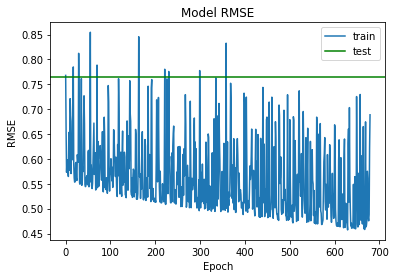

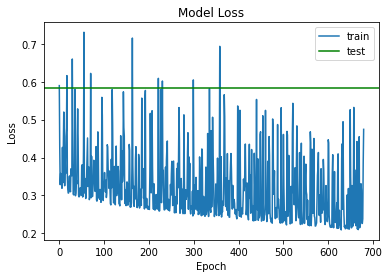

In [165]:
plt.plot(best_history.history['root_mean_squared_error'], label='train')
plt.axhline(test_rmse, color='g', label='test')
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend()
fpath = os.path.join("plots", now + " Model RMSE vs Epoch" + ".png")
if check_file(fpath):
    print("Could not save: {0}\nPossibly change datetime".format(fpath))
else:
    plt.savefig(fpath)
plt.show()

plt.plot(best_history.history['loss'], label='train')
plt.axhline(test_loss, color='g', label='test')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
fpath = os.path.join("plots", now + " Model Loss vs Epoch" + ".png")
if check_file(fpath):
    print("Could not save: {0}\nPossibly change datetime".format(fpath))
else:
    plt.savefig(fpath)
plt.show()

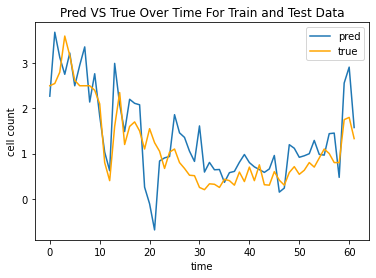

In [166]:
pred = best_model.predict(x_shaped)

plt.plot(pred, label='pred')
plt.plot(y_shaped, color='orange', label='true')
plt.title('Pred VS True Over Time For Train and Test Data')
plt.ylabel('cell count')
plt.xlabel('time')
plt.legend()
fpath = os.path.join("plots", now + " Overall Acc Predicted and True vs Time" + ".png")
if check_file(fpath):
    print("Could not save: {0}\nPossibly change datetime".format(fpath))
else:
    plt.savefig(fpath)
plt.show()
